In [3]:
def data_fetch():
    
    import pandas as pd
    import numpy as np

    path_to_data_file = "/home/shreyas/Documents/AirQualityUCI/AirQualityUCI.xlsx"
    df = pd.read_excel(path_to_data_file)
    df.head()
    return df

In [4]:
def data_clean(df):
    
    df = df.drop(["Date","Time"],axis=1)
    df.head()

    # Replace -200 (i.e. missing values) to mean value
    df[:] = df[:].replace(-200,np.nan)
    df.fillna(df.mean(), inplace=True)
    return df

In [5]:
def normalize(dataset):
    dataNorm=((dataset-dataset.min())/(dataset.max()-dataset.min()))
    return dataNorm





'df_normalize = normalize(df)\ndf_normalize.head(5)'

In [7]:
def autoencoder_train(x_train):
    

    # Autoencoder
    input_size = 13
    hidden_size_1 = 12
    hidden_size_2 = 12
    code_size = 12
    activation = 'tanh'

    input_layer = Input(shape=(input_size,))
    hidden_1 = Dense(hidden_size_1, activation=activation)(input_layer)
    hidden_12 = Dense(hidden_size_2, activation=activation)(hidden_1)
    code = Dense(code_size)(hidden_12)
    hidden_22 = Dense(hidden_size_2, activation=activation)(code)
    hidden_2 = Dense(hidden_size_1, activation=activation)(hidden_22)
    output_layer = Dense(input_size)(hidden_2)

    # input_layer = Input(shape=(input_size,))
    # hidden_1 = Dense(hidden_size_1, activation='tanh')(input_layer)
    # code = Dense(code_size)(hidden_1)
    # hidden_2 = Dense(hidden_size_1, activation='tanh')(code)
    # output_layer = Dense(input_size)(hidden_2)

    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer=Adam(lr=0.001, epsilon=1e-08), loss='mse', metrics=['mape'])
    history = autoencoder.fit(x_train, x_train, epochs=1000, validation_split=0.2, batch_size=32)
    plotter(history)
    return autoencoder



In [9]:
 def plotter(history):   
   
    historydf = pd.DataFrame(history.history, index=history.epoch)
    #plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()
    


In [272]:
# Using encoder from Autoencoder to build output for koopman model#2

def Koopman_trainer(autoencoder_model,forward_time_steps,x_train):
    
    layer_name = "code"
    Encoder = Model(inputs=autoencoder_model.input,
                    outputs=autoencoder_model.layers[3].output)


    #forward_time_steps = 1
    x_train_ft = x_train.shift(-forward_time_steps, axis=0)

    # training input for Koopman
    x_train_koopman = x_train.drop(x_train.tail(forward_time_steps).index)
    print(x_train_koopman.shape)

    # Training output for Koopman
    x_train_ft_koopman = x_train_ft.drop(x_train_ft.tail(forward_time_steps).index)
    print(x_train_ft_koopman.shape)
    intermediate_output = Encoder.predict(x_train_ft_koopman)
    print(intermediate_output.shape)
    x_train_ft_codelayer_koopman = pd.DataFrame(data=intermediate_output[:,:])

    x_train_ft_codelayer_koopman.head()

    # Input shape = Output shape


    # x_train_ft_codelayer_koopman.head(-1)
    
    # Building the model.
    
    input_layer_k = Input(shape=(input_size,))
    hidden_1_k = Dense(hidden_size_1, activation=activation, trainable=False)(input_layer_k)
    hidden_12_k = Dense(hidden_size_2, activation=activation, trainable=False)(hidden_1_k)
    code_k = Dense(code_size, trainable=False)(hidden_12_k)
    code_2_k = Dense(code_size)(code_k)

    koopman = Model(input_layer_k, code_2_k)

    wt = autoencoder_model.layers[1].get_weights()
    koopman.layers[1].set_weights(wt)
    wt = autoencoder_model.layers[2].get_weights()
    koopman.layers[2].set_weights(wt)
    wt = autoencoder_model.layers[3].get_weights()
    koopman.layers[3].set_weights(wt)

    #print(koopman.summary())

    koopman.compile(optimizer=Adam(epsilon=1e-08), loss='mse', metrics=['mape'])
    history_k = koopman.fit(x_train_koopman, x_train_ft_codelayer_koopman, epochs=1000, validation_split=0.2, batch_size=64)
    plotter(history_k)
    
    return koopman



In [57]:
def fullmodel_predict(autoencoder,koopman,input_data,forward_time_steps):    
    
    input_koopman = input_data.drop(input_data.tail(forward_time_steps).index)
    intermediate_code = koopman.predict(input_koopman)
    coded_layer = pd.DataFrame(data=intermediate_code[:,:])
    
    return coded_layer

In [127]:
def decoder(autoencoder,coded_layer):
    
        idx = 4
        input_shape = autoencoder.layers[idx].get_input_shape_at(0)
        print(input_shape)
        layer_input = Input(shape=input_shape[1])
        print(layer_input.shape)
        x = layer_input
        
        for layer in autoencoder.layers[idx:]:
            x = layer(x)
        
        decoder = Model(layer_input, x)
        
        
        #return decoder
         
        output_layer = decoder.predict(coded_layer)
        output_values = pd.DataFrame(data=output_layer[:,:])
        
        return output_values

In [151]:
def save_xls(dict_df, path):
    """
    Save a dictionary of dataframes to an excel file, with each dataframe as a seperate page
    """

    writer = ExcelWriter(path)
    for key in dict_df:
        dict_df[key].to_excel(writer, key)

    writer.save()

In [148]:
import pandas as pd
from pandas import ExcelWriter
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import tensorflow.keras 
tensorflow.keras.backend.set_epsilon(0.01) # For mape error
import random as rand
import os

input_size = 13
hidden_size_1 = 12
hidden_size_2 = 12
code_size = 12
activation = 'tanh'

output_dict = {}

In [325]:
# Data Prep
df = data_fetch()
df_cleaned = data_clean(df)
x_total = normalize(df_cleaned)
x_train = x_total[:8000]
x_train.shape

(8000, 13)

W0329 09:28:19.099882 140619686774592 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


Train on 7485 samples, validate on 1872 samples
Epoch 1/1000
7485/7485 [==============================] - 0s 65us/sample - loss: 0.0273 - mape: 47.4114 - val_loss: 0.0100 - val_mape: 50.9049
Epoch 2/1000
7485/7485 [==============================] - 0s 53us/sample - loss: 0.0055 - mape: 27.3817 - val_loss: 0.0059 - val_mape: 37.2873
Epoch 3/1000
7485/7485 [==============================] - 0s 49us/sample - loss: 0.0032 - mape: 21.8222 - val_loss: 0.0039 - val_mape: 32.9341
Epoch 4/1000
7485/7485 [==============================] - 0s 46us/sample - loss: 0.0021 - mape: 18.6485 - val_loss: 0.0032 - val_mape: 29.9858
Epoch 5/1000
7485/7485 [==============================] - 0s 48us/sample - loss: 0.0017 - mape: 16.6940 - val_loss: 0.0025 - val_mape: 26.1705
Epoch 6/1000
7485/7485 [==============================] - 0s 48us/sample - loss: 0.0015 - mape: 15.4922 - val_loss: 0.0024 - val_mape: 25.7272
Epoch 7/1000
7485/7485 [==============================] - 0s 46us/sample - loss: 0.0013 - mape

7485/7485 [==============================] - 0s 45us/sample - loss: 1.3070e-04 - mape: 4.9387 - val_loss: 1.7907e-04 - val_mape: 8.3196
Epoch 56/1000
7485/7485 [==============================] - 0s 46us/sample - loss: 1.2879e-04 - mape: 4.9485 - val_loss: 1.8778e-04 - val_mape: 8.7557
Epoch 57/1000
7485/7485 [==============================] - 0s 47us/sample - loss: 1.2457e-04 - mape: 4.8655 - val_loss: 1.8765e-04 - val_mape: 8.7121
Epoch 58/1000
7485/7485 [==============================] - 0s 46us/sample - loss: 1.2198e-04 - mape: 4.8255 - val_loss: 1.5983e-04 - val_mape: 7.8626
Epoch 59/1000
7485/7485 [==============================] - 0s 45us/sample - loss: 1.1934e-04 - mape: 4.7562 - val_loss: 1.7076e-04 - val_mape: 8.3833
Epoch 60/1000
7485/7485 [==============================] - 0s 50us/sample - loss: 1.1824e-04 - mape: 4.7383 - val_loss: 1.6250e-04 - val_mape: 8.0085
Epoch 61/1000
7485/7485 [==============================] - 0s 49us/sample - loss: 1.1742e-04 - mape: 4.7123 - val_

7485/7485 [==============================] - 0s 45us/sample - loss: 9.0674e-05 - mape: 3.7736 - val_loss: 1.2798e-04 - val_mape: 7.9273
Epoch 110/1000
7485/7485 [==============================] - 0s 43us/sample - loss: 9.1020e-05 - mape: 3.7779 - val_loss: 1.2088e-04 - val_mape: 7.6405
Epoch 111/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 9.1604e-05 - mape: 3.8003 - val_loss: 1.1471e-04 - val_mape: 7.5174
Epoch 112/1000
7485/7485 [==============================] - 0s 49us/sample - loss: 9.1692e-05 - mape: 3.8165 - val_loss: 1.1092e-04 - val_mape: 7.2555
Epoch 113/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 9.0217e-05 - mape: 3.7669 - val_loss: 1.1268e-04 - val_mape: 7.6984
Epoch 114/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 9.0701e-05 - mape: 3.7706 - val_loss: 1.1910e-04 - val_mape: 7.8404
Epoch 115/1000
7485/7485 [==============================] - 0s 45us/sample - loss: 9.0581e-05 - mape: 3.7825 

7485/7485 [==============================] - 0s 44us/sample - loss: 8.7871e-05 - mape: 3.7331 - val_loss: 1.2816e-04 - val_mape: 7.8405
Epoch 164/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 8.7704e-05 - mape: 3.7478 - val_loss: 1.2367e-04 - val_mape: 8.0637
Epoch 165/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 8.6057e-05 - mape: 3.6897 - val_loss: 1.3911e-04 - val_mape: 8.5388
Epoch 166/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 8.7240e-05 - mape: 3.7267 - val_loss: 1.5120e-04 - val_mape: 9.0663
Epoch 167/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 8.6478e-05 - mape: 3.7026 - val_loss: 1.5507e-04 - val_mape: 9.0675
Epoch 168/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 8.6849e-05 - mape: 3.7126 - val_loss: 1.4354e-04 - val_mape: 8.6421
Epoch 169/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 8.6788e-05 - mape: 3.7091 

7485/7485 [==============================] - 0s 45us/sample - loss: 8.5980e-05 - mape: 3.7053 - val_loss: 1.4775e-04 - val_mape: 8.8896
Epoch 218/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 8.4581e-05 - mape: 3.6773 - val_loss: 1.4214e-04 - val_mape: 8.4809
Epoch 219/1000
7485/7485 [==============================] - 0s 45us/sample - loss: 8.4770e-05 - mape: 3.6717 - val_loss: 1.5417e-04 - val_mape: 9.0901
Epoch 220/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 8.5255e-05 - mape: 3.6868 - val_loss: 1.4931e-04 - val_mape: 8.7790
Epoch 221/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 8.5739e-05 - mape: 3.7187 - val_loss: 1.5114e-04 - val_mape: 8.6402
Epoch 222/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 8.5149e-05 - mape: 3.6772 - val_loss: 1.5217e-04 - val_mape: 8.8593
Epoch 223/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 8.4950e-05 - mape: 3.6946 

7485/7485 [==============================] - 0s 44us/sample - loss: 8.1455e-05 - mape: 3.6002 - val_loss: 1.1831e-04 - val_mape: 7.7378
Epoch 272/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 8.2738e-05 - mape: 3.6585 - val_loss: 1.4817e-04 - val_mape: 8.5583
Epoch 273/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 8.2162e-05 - mape: 3.6220 - val_loss: 1.6417e-04 - val_mape: 9.3789
Epoch 274/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 8.2636e-05 - mape: 3.6489 - val_loss: 1.3322e-04 - val_mape: 8.2194
Epoch 275/1000
7485/7485 [==============================] - 0s 45us/sample - loss: 8.1712e-05 - mape: 3.6182 - val_loss: 1.2354e-04 - val_mape: 7.9062
Epoch 276/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 8.1589e-05 - mape: 3.5938 - val_loss: 1.1430e-04 - val_mape: 7.5486
Epoch 277/1000
7485/7485 [==============================] - 0s 43us/sample - loss: 8.1357e-05 - mape: 3.6177 

7485/7485 [==============================] - 0s 50us/sample - loss: 7.0234e-05 - mape: 3.0906 - val_loss: 9.4631e-05 - val_mape: 5.5635
Epoch 326/1000
7485/7485 [==============================] - 0s 51us/sample - loss: 6.8844e-05 - mape: 3.0290 - val_loss: 7.8845e-05 - val_mape: 4.8860
Epoch 327/1000
7485/7485 [==============================] - 0s 50us/sample - loss: 6.9139e-05 - mape: 3.0370 - val_loss: 7.7711e-05 - val_mape: 4.8576
Epoch 328/1000
7485/7485 [==============================] - 0s 50us/sample - loss: 6.9345e-05 - mape: 3.0642 - val_loss: 7.7897e-05 - val_mape: 4.6725
Epoch 329/1000
7485/7485 [==============================] - 0s 52us/sample - loss: 7.0445e-05 - mape: 3.0853 - val_loss: 8.3001e-05 - val_mape: 4.9404
Epoch 330/1000
7485/7485 [==============================] - 0s 51us/sample - loss: 6.8420e-05 - mape: 3.0120 - val_loss: 7.9895e-05 - val_mape: 4.8452
Epoch 331/1000
7485/7485 [==============================] - 0s 51us/sample - loss: 6.7449e-05 - mape: 2.9924 

7485/7485 [==============================] - 0s 50us/sample - loss: 5.6763e-05 - mape: 2.6849 - val_loss: 6.6376e-05 - val_mape: 3.8870
Epoch 380/1000
7485/7485 [==============================] - 0s 50us/sample - loss: 5.5454e-05 - mape: 2.6013 - val_loss: 8.4616e-05 - val_mape: 4.3097
Epoch 381/1000
7485/7485 [==============================] - 0s 49us/sample - loss: 5.5321e-05 - mape: 2.6033 - val_loss: 9.7868e-05 - val_mape: 4.3492
Epoch 382/1000
7485/7485 [==============================] - 0s 50us/sample - loss: 5.5310e-05 - mape: 2.6301 - val_loss: 6.5061e-05 - val_mape: 3.9224
Epoch 383/1000
7485/7485 [==============================] - 0s 47us/sample - loss: 5.4696e-05 - mape: 2.6062 - val_loss: 7.6374e-05 - val_mape: 4.0734
Epoch 384/1000
7485/7485 [==============================] - 0s 49us/sample - loss: 5.3712e-05 - mape: 2.5914 - val_loss: 7.5849e-05 - val_mape: 4.2436
Epoch 385/1000
7485/7485 [==============================] - 0s 49us/sample - loss: 5.1877e-05 - mape: 2.5322 

7485/7485 [==============================] - 0s 45us/sample - loss: 1.7879e-05 - mape: 1.7082 - val_loss: 4.2479e-05 - val_mape: 4.0194
Epoch 434/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 1.6869e-05 - mape: 1.6469 - val_loss: 4.1840e-05 - val_mape: 4.2765
Epoch 435/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 1.7080e-05 - mape: 1.6735 - val_loss: 4.3952e-05 - val_mape: 4.4585
Epoch 436/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 1.6699e-05 - mape: 1.6433 - val_loss: 3.9128e-05 - val_mape: 4.2452
Epoch 437/1000
7485/7485 [==============================] - 0s 45us/sample - loss: 1.6558e-05 - mape: 1.6315 - val_loss: 3.4869e-05 - val_mape: 4.0823
Epoch 438/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 1.6452e-05 - mape: 1.6403 - val_loss: 4.3274e-05 - val_mape: 4.2868
Epoch 439/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 1.6643e-05 - mape: 1.6576 

7485/7485 [==============================] - 0s 45us/sample - loss: 1.5905e-05 - mape: 1.6273 - val_loss: 3.3209e-05 - val_mape: 3.9659
Epoch 488/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 1.5741e-05 - mape: 1.6230 - val_loss: 3.3392e-05 - val_mape: 3.8513
Epoch 489/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 1.5610e-05 - mape: 1.5802 - val_loss: 3.9603e-05 - val_mape: 4.4598
Epoch 490/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 1.5826e-05 - mape: 1.5949 - val_loss: 4.3937e-05 - val_mape: 4.4372
Epoch 491/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 1.5399e-05 - mape: 1.5798 - val_loss: 3.6564e-05 - val_mape: 4.2871
Epoch 492/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 1.6029e-05 - mape: 1.6286 - val_loss: 3.6184e-05 - val_mape: 3.9083
Epoch 493/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 1.5432e-05 - mape: 1.5912 

7485/7485 [==============================] - 0s 46us/sample - loss: 1.5264e-05 - mape: 1.5504 - val_loss: 4.9748e-05 - val_mape: 4.7354
Epoch 542/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 1.5766e-05 - mape: 1.5991 - val_loss: 4.8761e-05 - val_mape: 4.9612
Epoch 543/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 1.5158e-05 - mape: 1.5565 - val_loss: 4.0887e-05 - val_mape: 4.3963
Epoch 544/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 1.5570e-05 - mape: 1.5889 - val_loss: 3.8243e-05 - val_mape: 4.2163
Epoch 545/1000
7485/7485 [==============================] - 0s 45us/sample - loss: 1.5170e-05 - mape: 1.5515 - val_loss: 4.2629e-05 - val_mape: 4.6352
Epoch 546/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 1.5687e-05 - mape: 1.6053 - val_loss: 4.2809e-05 - val_mape: 4.4937
Epoch 547/1000
7485/7485 [==============================] - 0s 45us/sample - loss: 1.5814e-05 - mape: 1.6293 

7485/7485 [==============================] - 0s 45us/sample - loss: 1.5194e-05 - mape: 1.5538 - val_loss: 3.4972e-05 - val_mape: 4.1302
Epoch 596/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 1.5129e-05 - mape: 1.5673 - val_loss: 3.8434e-05 - val_mape: 4.2222
Epoch 597/1000
7485/7485 [==============================] - 0s 45us/sample - loss: 1.5448e-05 - mape: 1.5828 - val_loss: 3.6880e-05 - val_mape: 4.3767
Epoch 598/1000
7485/7485 [==============================] - 0s 45us/sample - loss: 1.4715e-05 - mape: 1.5279 - val_loss: 3.8073e-05 - val_mape: 4.1736
Epoch 599/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 1.6583e-05 - mape: 1.6611 - val_loss: 3.9801e-05 - val_mape: 4.4023
Epoch 600/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 1.4984e-05 - mape: 1.5503 - val_loss: 4.2376e-05 - val_mape: 4.3352
Epoch 601/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 1.5303e-05 - mape: 1.5648 

7485/7485 [==============================] - 0s 60us/sample - loss: 1.5320e-05 - mape: 1.5951 - val_loss: 3.6282e-05 - val_mape: 4.1467
Epoch 650/1000
7485/7485 [==============================] - 0s 60us/sample - loss: 1.5334e-05 - mape: 1.5706 - val_loss: 4.4329e-05 - val_mape: 4.7092
Epoch 651/1000
7485/7485 [==============================] - 0s 52us/sample - loss: 1.4527e-05 - mape: 1.4895 - val_loss: 4.5129e-05 - val_mape: 4.4106
Epoch 652/1000
7485/7485 [==============================] - 0s 55us/sample - loss: 1.5123e-05 - mape: 1.5535 - val_loss: 3.8000e-05 - val_mape: 4.2687
Epoch 653/1000
7485/7485 [==============================] - 1s 82us/sample - loss: 1.5174e-05 - mape: 1.5494 - val_loss: 4.5609e-05 - val_mape: 5.2213
Epoch 654/1000
7485/7485 [==============================] - 1s 76us/sample - loss: 1.5100e-05 - mape: 1.5418 - val_loss: 4.1128e-05 - val_mape: 4.4739
Epoch 655/1000
7485/7485 [==============================] - 0s 57us/sample - loss: 1.5028e-05 - mape: 1.5508 

7485/7485 [==============================] - 0s 45us/sample - loss: 1.5415e-05 - mape: 1.5575 - val_loss: 4.5378e-05 - val_mape: 4.7376
Epoch 704/1000
7485/7485 [==============================] - 0s 45us/sample - loss: 1.5231e-05 - mape: 1.5594 - val_loss: 2.6579e-05 - val_mape: 3.5984
Epoch 705/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 1.5077e-05 - mape: 1.5618 - val_loss: 3.1306e-05 - val_mape: 3.8585
Epoch 706/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 1.4702e-05 - mape: 1.5272 - val_loss: 3.5227e-05 - val_mape: 4.0088
Epoch 707/1000
7485/7485 [==============================] - 0s 45us/sample - loss: 1.4989e-05 - mape: 1.5611 - val_loss: 3.3257e-05 - val_mape: 4.0671
Epoch 708/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 1.5710e-05 - mape: 1.5850 - val_loss: 4.0569e-05 - val_mape: 4.5329
Epoch 709/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 1.4924e-05 - mape: 1.5296 

7485/7485 [==============================] - 0s 45us/sample - loss: 1.5102e-05 - mape: 1.5417 - val_loss: 3.9070e-05 - val_mape: 4.2764
Epoch 758/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 1.4750e-05 - mape: 1.5331 - val_loss: 5.0581e-05 - val_mape: 5.6165
Epoch 759/1000
7485/7485 [==============================] - 0s 46us/sample - loss: 1.5853e-05 - mape: 1.6085 - val_loss: 3.3003e-05 - val_mape: 3.9163
Epoch 760/1000
7485/7485 [==============================] - 0s 45us/sample - loss: 1.5235e-05 - mape: 1.5475 - val_loss: 4.2415e-05 - val_mape: 4.5345
Epoch 761/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 1.5085e-05 - mape: 1.5688 - val_loss: 3.2330e-05 - val_mape: 3.8743
Epoch 762/1000
7485/7485 [==============================] - 0s 45us/sample - loss: 1.4915e-05 - mape: 1.5490 - val_loss: 3.8459e-05 - val_mape: 4.4835
Epoch 763/1000
7485/7485 [==============================] - 0s 52us/sample - loss: 1.5301e-05 - mape: 1.5575 

7485/7485 [==============================] - 0s 52us/sample - loss: 1.4786e-05 - mape: 1.5236 - val_loss: 3.4451e-05 - val_mape: 4.3353
Epoch 812/1000
7485/7485 [==============================] - 0s 48us/sample - loss: 1.5716e-05 - mape: 1.5968 - val_loss: 3.4621e-05 - val_mape: 3.9163
Epoch 813/1000
7485/7485 [==============================] - 0s 49us/sample - loss: 1.5474e-05 - mape: 1.5766 - val_loss: 3.7702e-05 - val_mape: 4.2669
Epoch 814/1000
7485/7485 [==============================] - 0s 49us/sample - loss: 1.4732e-05 - mape: 1.5436 - val_loss: 3.4049e-05 - val_mape: 4.0437
Epoch 815/1000
7485/7485 [==============================] - 0s 47us/sample - loss: 1.5343e-05 - mape: 1.5750 - val_loss: 3.1858e-05 - val_mape: 3.9097
Epoch 816/1000
7485/7485 [==============================] - 0s 52us/sample - loss: 1.5258e-05 - mape: 1.5468 - val_loss: 3.2620e-05 - val_mape: 3.7129
Epoch 817/1000
7485/7485 [==============================] - 0s 50us/sample - loss: 1.4719e-05 - mape: 1.5042 

7485/7485 [==============================] - 0s 46us/sample - loss: 1.4556e-05 - mape: 1.5060 - val_loss: 3.3293e-05 - val_mape: 3.8342
Epoch 866/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 1.5520e-05 - mape: 1.5916 - val_loss: 3.8262e-05 - val_mape: 4.4386
Epoch 867/1000
7485/7485 [==============================] - 0s 43us/sample - loss: 1.6108e-05 - mape: 1.6214 - val_loss: 3.8217e-05 - val_mape: 4.3982
Epoch 868/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 1.4762e-05 - mape: 1.5048 - val_loss: 4.8071e-05 - val_mape: 4.5274
Epoch 869/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 1.5221e-05 - mape: 1.5675 - val_loss: 4.1162e-05 - val_mape: 4.7988
Epoch 870/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 1.4395e-05 - mape: 1.4892 - val_loss: 3.5455e-05 - val_mape: 4.1185
Epoch 871/1000
7485/7485 [==============================] - 0s 44us/sample - loss: 1.5610e-05 - mape: 1.5897 

7485/7485 [==============================] - 0s 49us/sample - loss: 1.4690e-05 - mape: 1.5073 - val_loss: 3.8191e-05 - val_mape: 4.2412
Epoch 920/1000
7485/7485 [==============================] - 0s 49us/sample - loss: 1.4436e-05 - mape: 1.4965 - val_loss: 3.6299e-05 - val_mape: 4.0867
Epoch 921/1000
7485/7485 [==============================] - 0s 50us/sample - loss: 1.5836e-05 - mape: 1.6210 - val_loss: 3.3833e-05 - val_mape: 3.9485
Epoch 922/1000
7485/7485 [==============================] - 0s 48us/sample - loss: 1.4949e-05 - mape: 1.5382 - val_loss: 3.3724e-05 - val_mape: 3.9075
Epoch 923/1000
7485/7485 [==============================] - 0s 50us/sample - loss: 1.4129e-05 - mape: 1.4591 - val_loss: 3.6287e-05 - val_mape: 4.3269
Epoch 924/1000
7485/7485 [==============================] - 0s 49us/sample - loss: 1.5303e-05 - mape: 1.5579 - val_loss: 3.6278e-05 - val_mape: 4.0457
Epoch 925/1000
7485/7485 [==============================] - 0s 49us/sample - loss: 1.4444e-05 - mape: 1.4894 

7485/7485 [==============================] - 0s 51us/sample - loss: 1.4662e-05 - mape: 1.5028 - val_loss: 4.3594e-05 - val_mape: 4.6732
Epoch 974/1000
7485/7485 [==============================] - 0s 50us/sample - loss: 1.4798e-05 - mape: 1.5446 - val_loss: 4.1238e-05 - val_mape: 4.5163
Epoch 975/1000
7485/7485 [==============================] - 0s 50us/sample - loss: 1.4824e-05 - mape: 1.5269 - val_loss: 3.5923e-05 - val_mape: 4.0222
Epoch 976/1000
7485/7485 [==============================] - 0s 48us/sample - loss: 1.4449e-05 - mape: 1.4975 - val_loss: 3.3973e-05 - val_mape: 4.0728
Epoch 977/1000
7485/7485 [==============================] - 0s 50us/sample - loss: 1.4589e-05 - mape: 1.5063 - val_loss: 3.6490e-05 - val_mape: 4.2405
Epoch 978/1000
7485/7485 [==============================] - 0s 49us/sample - loss: 1.5421e-05 - mape: 1.5858 - val_loss: 4.7179e-05 - val_mape: 4.8600
Epoch 979/1000
7485/7485 [==============================] - 0s 51us/sample - loss: 1.4699e-05 - mape: 1.5334 

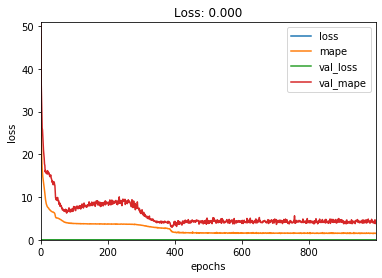

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 13)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 12)                168       
_________________________________________________________________
dense_7 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_8 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_9 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_10 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_11 (Dense)             (None, 13)                169 

In [17]:
#autoencoder_train
autoencoder_model = autoencoder_train(x_train)
print(autoencoder_model.summary())

(9356, 13)
(9356, 13)
(9356, 12)


W0330 14:30:41.110378 140619686774592 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


Train on 7484 samples, validate on 1872 samples
Epoch 1/1000
7484/7484 [==============================] - 0s 45us/sample - loss: 0.0035 - mape: 147.9372 - val_loss: 0.0037 - val_mape: 125.0751
Epoch 2/1000
7484/7484 [==============================] - 0s 28us/sample - loss: 0.0023 - mape: 111.3452 - val_loss: 0.0028 - val_mape: 100.1598
Epoch 3/1000
7484/7484 [==============================] - 0s 27us/sample - loss: 0.0016 - mape: 91.8890 - val_loss: 0.0022 - val_mape: 88.0056
Epoch 4/1000
7484/7484 [==============================] - 0s 25us/sample - loss: 0.0013 - mape: 80.7197 - val_loss: 0.0018 - val_mape: 81.0274
Epoch 5/1000
7484/7484 [==============================] - 0s 24us/sample - loss: 0.0010 - mape: 74.0564 - val_loss: 0.0015 - val_mape: 76.0896
Epoch 6/1000
7484/7484 [==============================] - 0s 29us/sample - loss: 8.9234e-04 - mape: 69.5922 - val_loss: 0.0013 - val_mape: 71.0103
Epoch 7/1000
7484/7484 [==============================] - 0s 31us/sample - loss: 8.019

Epoch 55/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9256e-04 - mape: 54.3198 - val_loss: 5.1142e-04 - val_mape: 48.6380
Epoch 56/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9297e-04 - mape: 54.2764 - val_loss: 5.0682e-04 - val_mape: 48.4893
Epoch 57/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9283e-04 - mape: 54.3073 - val_loss: 5.1552e-04 - val_mape: 48.7406
Epoch 58/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9289e-04 - mape: 54.2842 - val_loss: 5.1198e-04 - val_mape: 48.4088
Epoch 59/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9302e-04 - mape: 54.4430 - val_loss: 5.0911e-04 - val_mape: 47.8759
Epoch 60/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9258e-04 - mape: 54.2911 - val_loss: 5.1058e-04 - val_mape: 48.1997
Epoch 61/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9270

Epoch 109/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9313e-04 - mape: 54.3805 - val_loss: 5.1181e-04 - val_mape: 48.4628
Epoch 110/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9250e-04 - mape: 54.3107 - val_loss: 5.1358e-04 - val_mape: 48.4376
Epoch 111/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9269e-04 - mape: 54.3510 - val_loss: 5.0760e-04 - val_mape: 47.9891
Epoch 112/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9361e-04 - mape: 54.4229 - val_loss: 5.1246e-04 - val_mape: 48.3244
Epoch 113/1000
7484/7484 [==============================] - 0s 57us/sample - loss: 4.9287e-04 - mape: 54.3127 - val_loss: 5.0911e-04 - val_mape: 48.4696
Epoch 114/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9302e-04 - mape: 54.2834 - val_loss: 5.1187e-04 - val_mape: 48.4444
Epoch 115/1000
7484/7484 [==============================] - 0s 22us/sample - loss:

7484/7484 [==============================] - 0s 25us/sample - loss: 4.9320e-04 - mape: 54.3630 - val_loss: 5.0990e-04 - val_mape: 48.7549
Epoch 163/1000
7484/7484 [==============================] - 0s 24us/sample - loss: 4.9372e-04 - mape: 54.4134 - val_loss: 5.0889e-04 - val_mape: 48.0329
Epoch 164/1000
7484/7484 [==============================] - 0s 24us/sample - loss: 4.9309e-04 - mape: 54.3160 - val_loss: 5.1240e-04 - val_mape: 48.4475
Epoch 165/1000
7484/7484 [==============================] - 0s 24us/sample - loss: 4.9242e-04 - mape: 54.2283 - val_loss: 5.1003e-04 - val_mape: 48.4408
Epoch 166/1000
7484/7484 [==============================] - 0s 24us/sample - loss: 4.9300e-04 - mape: 54.2948 - val_loss: 5.1677e-04 - val_mape: 49.1381
Epoch 167/1000
7484/7484 [==============================] - 0s 24us/sample - loss: 4.9310e-04 - mape: 54.3298 - val_loss: 5.0536e-04 - val_mape: 47.9763
Epoch 168/1000
7484/7484 [==============================] - 0s 24us/sample - loss: 4.9279e-04 - m

7484/7484 [==============================] - 0s 23us/sample - loss: 4.9248e-04 - mape: 54.2950 - val_loss: 5.0955e-04 - val_mape: 48.2031
Epoch 216/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9248e-04 - mape: 54.2048 - val_loss: 5.1038e-04 - val_mape: 48.7713
Epoch 217/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9300e-04 - mape: 54.4292 - val_loss: 5.1148e-04 - val_mape: 48.4069
Epoch 218/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9264e-04 - mape: 54.3513 - val_loss: 5.0878e-04 - val_mape: 47.9446
Epoch 219/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9268e-04 - mape: 54.3265 - val_loss: 5.0667e-04 - val_mape: 47.7536
Epoch 220/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9278e-04 - mape: 54.2571 - val_loss: 5.1484e-04 - val_mape: 48.2754
Epoch 221/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9321e-04 - m

7484/7484 [==============================] - 0s 23us/sample - loss: 4.9268e-04 - mape: 54.3544 - val_loss: 5.1342e-04 - val_mape: 48.8540
Epoch 269/1000
7484/7484 [==============================] - 0s 24us/sample - loss: 4.9267e-04 - mape: 54.2669 - val_loss: 5.0981e-04 - val_mape: 48.4740
Epoch 270/1000
7484/7484 [==============================] - 0s 24us/sample - loss: 4.9296e-04 - mape: 54.3306 - val_loss: 5.1001e-04 - val_mape: 48.0574
Epoch 271/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9252e-04 - mape: 54.2049 - val_loss: 5.1562e-04 - val_mape: 49.0003
Epoch 272/1000
7484/7484 [==============================] - 0s 25us/sample - loss: 4.9281e-04 - mape: 54.3534 - val_loss: 5.1358e-04 - val_mape: 48.5663
Epoch 273/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9249e-04 - mape: 54.3303 - val_loss: 5.0930e-04 - val_mape: 48.2093
Epoch 274/1000
7484/7484 [==============================] - 0s 24us/sample - loss: 4.9280e-04 - m

7484/7484 [==============================] - 0s 22us/sample - loss: 4.9283e-04 - mape: 54.3200 - val_loss: 5.0647e-04 - val_mape: 47.9333
Epoch 322/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9303e-04 - mape: 54.3191 - val_loss: 5.1653e-04 - val_mape: 48.9761
Epoch 323/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9264e-04 - mape: 54.3353 - val_loss: 5.0838e-04 - val_mape: 47.9827
Epoch 324/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9273e-04 - mape: 54.2140 - val_loss: 5.1149e-04 - val_mape: 48.7463
Epoch 325/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9275e-04 - mape: 54.3440 - val_loss: 5.0777e-04 - val_mape: 48.0563
Epoch 326/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9275e-04 - mape: 54.2992 - val_loss: 5.1301e-04 - val_mape: 48.3434
Epoch 327/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9312e-04 - m

7484/7484 [==============================] - 0s 22us/sample - loss: 4.9314e-04 - mape: 54.3127 - val_loss: 5.1576e-04 - val_mape: 48.8091
Epoch 375/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9238e-04 - mape: 54.3735 - val_loss: 5.1283e-04 - val_mape: 48.0907
Epoch 376/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9346e-04 - mape: 54.2449 - val_loss: 5.0991e-04 - val_mape: 48.1645
Epoch 377/1000
7484/7484 [==============================] - 0s 24us/sample - loss: 4.9281e-04 - mape: 54.3422 - val_loss: 5.0779e-04 - val_mape: 48.3526
Epoch 378/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9323e-04 - mape: 54.2759 - val_loss: 5.1171e-04 - val_mape: 48.4306
Epoch 379/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9287e-04 - mape: 54.3570 - val_loss: 5.1274e-04 - val_mape: 48.6092
Epoch 380/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9301e-04 - m

7484/7484 [==============================] - 0s 22us/sample - loss: 4.9318e-04 - mape: 54.3168 - val_loss: 5.1124e-04 - val_mape: 48.4051
Epoch 428/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9303e-04 - mape: 54.4164 - val_loss: 5.0927e-04 - val_mape: 48.3289
Epoch 429/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9279e-04 - mape: 54.2945 - val_loss: 5.1093e-04 - val_mape: 48.6250
Epoch 430/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9264e-04 - mape: 54.2768 - val_loss: 5.1082e-04 - val_mape: 47.8227
Epoch 431/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9273e-04 - mape: 54.2962 - val_loss: 5.1164e-04 - val_mape: 48.3831
Epoch 432/1000
7484/7484 [==============================] - 0s 25us/sample - loss: 4.9285e-04 - mape: 54.3219 - val_loss: 5.1259e-04 - val_mape: 48.4493
Epoch 433/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9284e-04 - m

7484/7484 [==============================] - 0s 24us/sample - loss: 4.9298e-04 - mape: 54.3247 - val_loss: 5.1088e-04 - val_mape: 48.2197
Epoch 481/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9278e-04 - mape: 54.3031 - val_loss: 5.1081e-04 - val_mape: 48.8489
Epoch 482/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9315e-04 - mape: 54.3850 - val_loss: 5.1358e-04 - val_mape: 48.4929
Epoch 483/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9314e-04 - mape: 54.4265 - val_loss: 5.0935e-04 - val_mape: 48.0310
Epoch 484/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9329e-04 - mape: 54.3215 - val_loss: 5.0769e-04 - val_mape: 48.1818
Epoch 485/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9286e-04 - mape: 54.2608 - val_loss: 5.0770e-04 - val_mape: 48.2424
Epoch 486/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9269e-04 - m

7484/7484 [==============================] - 0s 23us/sample - loss: 4.9297e-04 - mape: 54.3736 - val_loss: 5.1003e-04 - val_mape: 48.2866
Epoch 534/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9306e-04 - mape: 54.4052 - val_loss: 5.0801e-04 - val_mape: 48.0777
Epoch 535/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9288e-04 - mape: 54.3053 - val_loss: 5.0501e-04 - val_mape: 47.7227
Epoch 536/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9289e-04 - mape: 54.3374 - val_loss: 5.0733e-04 - val_mape: 47.8461
Epoch 537/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9297e-04 - mape: 54.2969 - val_loss: 5.0753e-04 - val_mape: 47.9851
Epoch 538/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9243e-04 - mape: 54.2903 - val_loss: 5.0921e-04 - val_mape: 48.1725
Epoch 539/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9292e-04 - m

7484/7484 [==============================] - 0s 22us/sample - loss: 4.9275e-04 - mape: 54.2585 - val_loss: 5.1395e-04 - val_mape: 48.6397
Epoch 587/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9279e-04 - mape: 54.3465 - val_loss: 5.0924e-04 - val_mape: 48.4399
Epoch 588/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9318e-04 - mape: 54.3821 - val_loss: 5.0816e-04 - val_mape: 48.0369
Epoch 589/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9262e-04 - mape: 54.3842 - val_loss: 5.0915e-04 - val_mape: 47.9049
Epoch 590/1000
7484/7484 [==============================] - 0s 24us/sample - loss: 4.9286e-04 - mape: 54.2483 - val_loss: 5.1393e-04 - val_mape: 48.4184
Epoch 591/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9318e-04 - mape: 54.3167 - val_loss: 5.1392e-04 - val_mape: 48.7945
Epoch 592/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9219e-04 - m

7484/7484 [==============================] - 0s 23us/sample - loss: 4.9262e-04 - mape: 54.3741 - val_loss: 5.1386e-04 - val_mape: 48.5259
Epoch 640/1000
7484/7484 [==============================] - 0s 25us/sample - loss: 4.9338e-04 - mape: 54.3645 - val_loss: 5.1442e-04 - val_mape: 48.8800
Epoch 641/1000
7484/7484 [==============================] - 0s 25us/sample - loss: 4.9254e-04 - mape: 54.2616 - val_loss: 5.1148e-04 - val_mape: 48.5200
Epoch 642/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9284e-04 - mape: 54.3719 - val_loss: 5.1355e-04 - val_mape: 48.6030
Epoch 643/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9259e-04 - mape: 54.2716 - val_loss: 5.0943e-04 - val_mape: 48.6275
Epoch 644/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9321e-04 - mape: 54.4102 - val_loss: 5.2175e-04 - val_mape: 49.2398
Epoch 645/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9291e-04 - m

7484/7484 [==============================] - 0s 25us/sample - loss: 4.9268e-04 - mape: 54.3644 - val_loss: 5.1112e-04 - val_mape: 48.1679
Epoch 693/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9269e-04 - mape: 54.3070 - val_loss: 5.1132e-04 - val_mape: 48.3522
Epoch 694/1000
7484/7484 [==============================] - 0s 24us/sample - loss: 4.9317e-04 - mape: 54.3447 - val_loss: 5.1417e-04 - val_mape: 48.5980
Epoch 695/1000
7484/7484 [==============================] - 0s 24us/sample - loss: 4.9359e-04 - mape: 54.4066 - val_loss: 5.0522e-04 - val_mape: 47.9302
Epoch 696/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9293e-04 - mape: 54.3145 - val_loss: 5.0865e-04 - val_mape: 47.9170
Epoch 697/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9278e-04 - mape: 54.3576 - val_loss: 5.1049e-04 - val_mape: 48.2246
Epoch 698/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9292e-04 - m

7484/7484 [==============================] - 0s 23us/sample - loss: 4.9276e-04 - mape: 54.3844 - val_loss: 5.1141e-04 - val_mape: 48.7646
Epoch 746/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9325e-04 - mape: 54.4079 - val_loss: 5.1242e-04 - val_mape: 48.6692
Epoch 747/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9332e-04 - mape: 54.4193 - val_loss: 5.1087e-04 - val_mape: 47.9806
Epoch 748/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9254e-04 - mape: 54.2277 - val_loss: 5.0741e-04 - val_mape: 48.3468
Epoch 749/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9299e-04 - mape: 54.4087 - val_loss: 5.1612e-04 - val_mape: 48.8532
Epoch 750/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9312e-04 - mape: 54.3677 - val_loss: 5.0686e-04 - val_mape: 48.0718
Epoch 751/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9315e-04 - m

7484/7484 [==============================] - 0s 23us/sample - loss: 4.9275e-04 - mape: 54.3232 - val_loss: 5.1993e-04 - val_mape: 49.1195
Epoch 799/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9323e-04 - mape: 54.3523 - val_loss: 5.1268e-04 - val_mape: 48.4281
Epoch 800/1000
7484/7484 [==============================] - 0s 24us/sample - loss: 4.9255e-04 - mape: 54.3794 - val_loss: 5.1127e-04 - val_mape: 48.1026
Epoch 801/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9340e-04 - mape: 54.3735 - val_loss: 5.1118e-04 - val_mape: 48.3218
Epoch 802/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9295e-04 - mape: 54.4103 - val_loss: 5.0744e-04 - val_mape: 48.1545
Epoch 803/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9298e-04 - mape: 54.3200 - val_loss: 5.1319e-04 - val_mape: 47.9975
Epoch 804/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9258e-04 - m

7484/7484 [==============================] - 0s 23us/sample - loss: 4.9284e-04 - mape: 54.3904 - val_loss: 5.1518e-04 - val_mape: 48.7451
Epoch 852/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9330e-04 - mape: 54.3418 - val_loss: 5.1104e-04 - val_mape: 48.2903
Epoch 853/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9335e-04 - mape: 54.3151 - val_loss: 5.1495e-04 - val_mape: 48.4897
Epoch 854/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9305e-04 - mape: 54.3342 - val_loss: 5.1302e-04 - val_mape: 48.6622
Epoch 855/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9251e-04 - mape: 54.3255 - val_loss: 5.1228e-04 - val_mape: 48.5815
Epoch 856/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9247e-04 - mape: 54.2771 - val_loss: 5.1199e-04 - val_mape: 48.6344
Epoch 857/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9224e-04 - m

7484/7484 [==============================] - 0s 23us/sample - loss: 4.9267e-04 - mape: 54.2347 - val_loss: 5.1253e-04 - val_mape: 48.6014
Epoch 905/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9334e-04 - mape: 54.4029 - val_loss: 5.1719e-04 - val_mape: 49.3176
Epoch 906/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9291e-04 - mape: 54.2907 - val_loss: 5.1350e-04 - val_mape: 48.7666
Epoch 907/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9262e-04 - mape: 54.3158 - val_loss: 5.0665e-04 - val_mape: 47.9655
Epoch 908/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9250e-04 - mape: 54.3358 - val_loss: 5.0972e-04 - val_mape: 48.4327
Epoch 909/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9259e-04 - mape: 54.3155 - val_loss: 5.0655e-04 - val_mape: 47.6984
Epoch 910/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9306e-04 - m

7484/7484 [==============================] - 0s 23us/sample - loss: 4.9302e-04 - mape: 54.3293 - val_loss: 5.0951e-04 - val_mape: 48.1869
Epoch 958/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9321e-04 - mape: 54.3412 - val_loss: 5.0461e-04 - val_mape: 47.8748
Epoch 959/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 4.9325e-04 - mape: 54.3587 - val_loss: 5.1235e-04 - val_mape: 48.2987
Epoch 960/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9247e-04 - mape: 54.3322 - val_loss: 5.1058e-04 - val_mape: 48.1889
Epoch 961/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9286e-04 - mape: 54.2956 - val_loss: 5.0912e-04 - val_mape: 48.1805
Epoch 962/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9293e-04 - mape: 54.2692 - val_loss: 5.0654e-04 - val_mape: 48.1374
Epoch 963/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 4.9295e-04 - m

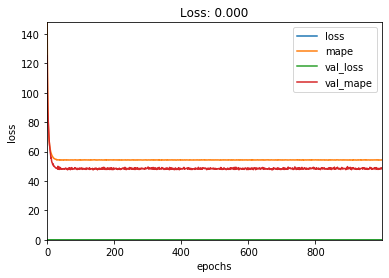

Model: "model_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        [(None, 13)]              0         
_________________________________________________________________
dense_36 (Dense)             (None, 12)                168       
_________________________________________________________________
dense_37 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_38 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_39 (Dense)             (None, 12)                156       
Total params: 636
Trainable params: 156
Non-trainable params: 480
_________________________________________________________________
None


In [273]:
#Koopman_train_timestep=1
Koopman_model_time1 = Koopman_trainer(autoencoder_model,1,x_train)
print(Koopman_model_time1.summary())

(9355, 13)
(9355, 13)
(9355, 12)


W0330 14:54:26.094474 140619686774592 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


Train on 7484 samples, validate on 1871 samples
Epoch 1/1000
7484/7484 [==============================] - 0s 40us/sample - loss: 0.0042 - mape: 177.6799 - val_loss: 0.0048 - val_mape: 142.4237
Epoch 2/1000
7484/7484 [==============================] - 0s 25us/sample - loss: 0.0026 - mape: 126.7127 - val_loss: 0.0031 - val_mape: 105.9694
Epoch 3/1000
7484/7484 [==============================] - 0s 27us/sample - loss: 0.0019 - mape: 102.9965 - val_loss: 0.0024 - val_mape: 92.8944
Epoch 4/1000
7484/7484 [==============================] - 0s 26us/sample - loss: 0.0015 - mape: 91.9107 - val_loss: 0.0020 - val_mape: 86.6029
Epoch 5/1000
7484/7484 [==============================] - 0s 26us/sample - loss: 0.0014 - mape: 86.0178 - val_loss: 0.0017 - val_mape: 81.5131
Epoch 6/1000
7484/7484 [==============================] - 0s 27us/sample - loss: 0.0013 - mape: 82.4241 - val_loss: 0.0015 - val_mape: 78.5037
Epoch 7/1000
7484/7484 [==============================] - 0s 28us/sample - loss: 0.0012 -

7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.5125 - val_loss: 0.0011 - val_mape: 67.3395
Epoch 58/1000
7484/7484 [==============================] - 0s 24us/sample - loss: 0.0010 - mape: 72.7632 - val_loss: 0.0011 - val_mape: 66.6074
Epoch 59/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.5478 - val_loss: 0.0011 - val_mape: 66.9072
Epoch 60/1000
7484/7484 [==============================] - 0s 24us/sample - loss: 0.0010 - mape: 72.7315 - val_loss: 0.0011 - val_mape: 67.6562
Epoch 61/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 0.0010 - mape: 72.6798 - val_loss: 0.0011 - val_mape: 67.0141
Epoch 62/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 0.0010 - mape: 72.6816 - val_loss: 0.0011 - val_mape: 66.0971
Epoch 63/1000
7484/7484 [==============================] - 0s 24us/sample - loss: 0.0010 - mape: 72.6267 - val_loss: 0.0011 - val_mape: 67.3785
Epoch 

Epoch 114/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 0.0010 - mape: 72.6531 - val_loss: 0.0011 - val_mape: 66.5909
Epoch 115/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.7143 - val_loss: 0.0011 - val_mape: 66.1984
Epoch 116/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.6429 - val_loss: 0.0011 - val_mape: 66.7312
Epoch 117/1000
7484/7484 [==============================] - 0s 21us/sample - loss: 0.0010 - mape: 72.5950 - val_loss: 0.0011 - val_mape: 66.2063
Epoch 118/1000
7484/7484 [==============================] - 0s 21us/sample - loss: 0.0010 - mape: 72.6877 - val_loss: 0.0011 - val_mape: 66.1829
Epoch 119/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.5634 - val_loss: 0.0011 - val_mape: 66.0639
Epoch 120/1000
7484/7484 [==============================] - 0s 21us/sample - loss: 0.0010 - mape: 72.6631 - val_loss: 0.0011 - val

7484/7484 [==============================] - 0s 21us/sample - loss: 0.0010 - mape: 72.7301 - val_loss: 0.0011 - val_mape: 67.4480
Epoch 171/1000
7484/7484 [==============================] - 0s 21us/sample - loss: 0.0010 - mape: 72.6426 - val_loss: 0.0011 - val_mape: 66.6352
Epoch 172/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.6894 - val_loss: 0.0011 - val_mape: 67.1612
Epoch 173/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 0.0010 - mape: 72.7015 - val_loss: 0.0011 - val_mape: 66.4431
Epoch 174/1000
7484/7484 [==============================] - 0s 21us/sample - loss: 0.0010 - mape: 72.6529 - val_loss: 0.0011 - val_mape: 66.4568
Epoch 175/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.6267 - val_loss: 0.0011 - val_mape: 66.1480
Epoch 176/1000
7484/7484 [==============================] - 0s 21us/sample - loss: 0.0010 - mape: 72.7278 - val_loss: 0.0011 - val_mape: 66.9321


7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.5841 - val_loss: 0.0011 - val_mape: 67.8049
Epoch 227/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.6348 - val_loss: 0.0011 - val_mape: 66.6996
Epoch 228/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.7692 - val_loss: 0.0011 - val_mape: 66.5229
Epoch 229/1000
7484/7484 [==============================] - 0s 27us/sample - loss: 0.0010 - mape: 72.7040 - val_loss: 0.0011 - val_mape: 66.5446
Epoch 230/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.6257 - val_loss: 0.0011 - val_mape: 66.8863
Epoch 231/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.6812 - val_loss: 0.0011 - val_mape: 67.0669
Epoch 232/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 0.0010 - mape: 72.6199 - val_loss: 0.0011 - val_mape: 66.2646


7484/7484 [==============================] - 0s 21us/sample - loss: 0.0010 - mape: 72.6411 - val_loss: 0.0011 - val_mape: 66.5886
Epoch 283/1000
7484/7484 [==============================] - 0s 21us/sample - loss: 0.0010 - mape: 72.6167 - val_loss: 0.0011 - val_mape: 66.2340
Epoch 284/1000
7484/7484 [==============================] - 0s 21us/sample - loss: 0.0010 - mape: 72.6485 - val_loss: 0.0011 - val_mape: 66.9756
Epoch 285/1000
7484/7484 [==============================] - 0s 21us/sample - loss: 0.0010 - mape: 72.5974 - val_loss: 0.0011 - val_mape: 67.1655
Epoch 286/1000
7484/7484 [==============================] - 0s 21us/sample - loss: 0.0010 - mape: 72.6757 - val_loss: 0.0011 - val_mape: 66.8327
Epoch 287/1000
7484/7484 [==============================] - 0s 21us/sample - loss: 0.0010 - mape: 72.7629 - val_loss: 0.0011 - val_mape: 66.5287
Epoch 288/1000
7484/7484 [==============================] - 0s 21us/sample - loss: 0.0010 - mape: 72.5985 - val_loss: 0.0011 - val_mape: 66.3839


7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.6104 - val_loss: 0.0011 - val_mape: 66.4509
Epoch 339/1000
7484/7484 [==============================] - 0s 21us/sample - loss: 0.0010 - mape: 72.7077 - val_loss: 0.0011 - val_mape: 67.0616
Epoch 340/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.6323 - val_loss: 0.0011 - val_mape: 66.3451
Epoch 341/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.6534 - val_loss: 0.0011 - val_mape: 66.6111
Epoch 342/1000
7484/7484 [==============================] - 0s 21us/sample - loss: 0.0010 - mape: 72.6105 - val_loss: 0.0011 - val_mape: 66.3048
Epoch 343/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.5529 - val_loss: 0.0011 - val_mape: 67.1360
Epoch 344/1000
7484/7484 [==============================] - 0s 24us/sample - loss: 0.0010 - mape: 72.7105 - val_loss: 0.0011 - val_mape: 67.2490


7484/7484 [==============================] - 0s 21us/sample - loss: 0.0010 - mape: 72.6008 - val_loss: 0.0011 - val_mape: 66.2374
Epoch 395/1000
7484/7484 [==============================] - 0s 21us/sample - loss: 0.0010 - mape: 72.6297 - val_loss: 0.0011 - val_mape: 66.7451
Epoch 396/1000
7484/7484 [==============================] - 0s 21us/sample - loss: 0.0010 - mape: 72.6838 - val_loss: 0.0011 - val_mape: 66.2401
Epoch 397/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.7215 - val_loss: 0.0011 - val_mape: 67.4388
Epoch 398/1000
7484/7484 [==============================] - 0s 21us/sample - loss: 0.0010 - mape: 72.6531 - val_loss: 0.0011 - val_mape: 67.6330
Epoch 399/1000
7484/7484 [==============================] - 0s 21us/sample - loss: 0.0010 - mape: 72.7155 - val_loss: 0.0011 - val_mape: 65.9110
Epoch 400/1000
7484/7484 [==============================] - 0s 21us/sample - loss: 0.0010 - mape: 72.5987 - val_loss: 0.0011 - val_mape: 67.2302


7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.6748 - val_loss: 0.0011 - val_mape: 66.8724
Epoch 451/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 0.0010 - mape: 72.6424 - val_loss: 0.0011 - val_mape: 66.6996
Epoch 452/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.7566 - val_loss: 0.0011 - val_mape: 66.1391
Epoch 453/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.5835 - val_loss: 0.0011 - val_mape: 65.9015
Epoch 454/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 0.0010 - mape: 72.7004 - val_loss: 0.0011 - val_mape: 66.2642
Epoch 455/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.6100 - val_loss: 0.0011 - val_mape: 66.9190
Epoch 456/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 0.0010 - mape: 72.7807 - val_loss: 0.0011 - val_mape: 66.7940


7484/7484 [==============================] - 0s 24us/sample - loss: 0.0010 - mape: 72.6705 - val_loss: 0.0011 - val_mape: 67.2853
Epoch 507/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 0.0010 - mape: 72.6520 - val_loss: 0.0011 - val_mape: 66.3850
Epoch 508/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.5481 - val_loss: 0.0011 - val_mape: 65.9800
Epoch 509/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 0.0010 - mape: 72.6854 - val_loss: 0.0011 - val_mape: 66.3845
Epoch 510/1000
7484/7484 [==============================] - 0s 25us/sample - loss: 0.0010 - mape: 72.6054 - val_loss: 0.0011 - val_mape: 67.3620
Epoch 511/1000
7484/7484 [==============================] - 0s 24us/sample - loss: 0.0010 - mape: 72.6474 - val_loss: 0.0011 - val_mape: 66.2797
Epoch 512/1000
7484/7484 [==============================] - 0s 30us/sample - loss: 0.0010 - mape: 72.6631 - val_loss: 0.0011 - val_mape: 66.4103


7484/7484 [==============================] - 0s 39us/sample - loss: 0.0010 - mape: 72.5836 - val_loss: 0.0011 - val_mape: 67.4935
Epoch 563/1000
7484/7484 [==============================] - 0s 38us/sample - loss: 0.0010 - mape: 72.7452 - val_loss: 0.0011 - val_mape: 66.3822
Epoch 564/1000
7484/7484 [==============================] - 0s 31us/sample - loss: 0.0010 - mape: 72.5967 - val_loss: 0.0011 - val_mape: 66.8987
Epoch 565/1000
7484/7484 [==============================] - 0s 25us/sample - loss: 0.0010 - mape: 72.5662 - val_loss: 0.0011 - val_mape: 66.5683
Epoch 566/1000
7484/7484 [==============================] - 0s 24us/sample - loss: 0.0010 - mape: 72.7573 - val_loss: 0.0011 - val_mape: 66.7279
Epoch 567/1000
7484/7484 [==============================] - 0s 27us/sample - loss: 0.0010 - mape: 72.5989 - val_loss: 0.0011 - val_mape: 66.8935
Epoch 568/1000
7484/7484 [==============================] - 0s 40us/sample - loss: 0.0010 - mape: 72.7950 - val_loss: 0.0011 - val_mape: 66.0450


7484/7484 [==============================] - 0s 24us/sample - loss: 0.0010 - mape: 72.7449 - val_loss: 0.0011 - val_mape: 66.4958
Epoch 619/1000
7484/7484 [==============================] - 0s 25us/sample - loss: 0.0010 - mape: 72.6126 - val_loss: 0.0011 - val_mape: 66.7421
Epoch 620/1000
7484/7484 [==============================] - 0s 25us/sample - loss: 0.0010 - mape: 72.7111 - val_loss: 0.0011 - val_mape: 66.4947
Epoch 621/1000
7484/7484 [==============================] - 0s 24us/sample - loss: 0.0010 - mape: 72.6193 - val_loss: 0.0011 - val_mape: 67.5830
Epoch 622/1000
7484/7484 [==============================] - 0s 24us/sample - loss: 0.0010 - mape: 72.6282 - val_loss: 0.0011 - val_mape: 66.9786
Epoch 623/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 0.0010 - mape: 72.7726 - val_loss: 0.0011 - val_mape: 66.4001
Epoch 624/1000
7484/7484 [==============================] - 0s 24us/sample - loss: 0.0010 - mape: 72.7151 - val_loss: 0.0011 - val_mape: 66.8145


7484/7484 [==============================] - 0s 23us/sample - loss: 0.0010 - mape: 72.7647 - val_loss: 0.0011 - val_mape: 66.9530
Epoch 675/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 0.0010 - mape: 72.6100 - val_loss: 0.0011 - val_mape: 66.7260
Epoch 676/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 0.0010 - mape: 72.6922 - val_loss: 0.0011 - val_mape: 67.1604
Epoch 677/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.6460 - val_loss: 0.0011 - val_mape: 65.9720
Epoch 678/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.5245 - val_loss: 0.0011 - val_mape: 65.9572
Epoch 679/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 0.0010 - mape: 72.6674 - val_loss: 0.0011 - val_mape: 66.2738
Epoch 680/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.6394 - val_loss: 0.0011 - val_mape: 66.3644


7484/7484 [==============================] - 0s 24us/sample - loss: 0.0010 - mape: 72.7510 - val_loss: 0.0011 - val_mape: 65.9293
Epoch 731/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 0.0010 - mape: 72.6768 - val_loss: 0.0011 - val_mape: 66.9861
Epoch 732/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 0.0010 - mape: 72.6978 - val_loss: 0.0011 - val_mape: 66.9707
Epoch 733/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 0.0010 - mape: 72.7109 - val_loss: 0.0011 - val_mape: 66.1576
Epoch 734/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 0.0010 - mape: 72.5352 - val_loss: 0.0011 - val_mape: 66.8923
Epoch 735/1000
7484/7484 [==============================] - 0s 25us/sample - loss: 0.0010 - mape: 72.6685 - val_loss: 0.0011 - val_mape: 66.7439
Epoch 736/1000
7484/7484 [==============================] - 0s 24us/sample - loss: 0.0010 - mape: 72.6115 - val_loss: 0.0011 - val_mape: 66.1178


7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.6320 - val_loss: 0.0011 - val_mape: 66.7414
Epoch 787/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 0.0010 - mape: 72.7187 - val_loss: 0.0011 - val_mape: 66.6358
Epoch 788/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 0.0010 - mape: 72.6613 - val_loss: 0.0011 - val_mape: 66.3937
Epoch 789/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 0.0010 - mape: 72.5527 - val_loss: 0.0011 - val_mape: 66.4497
Epoch 790/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 0.0010 - mape: 72.5760 - val_loss: 0.0011 - val_mape: 66.7417
Epoch 791/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.8793 - val_loss: 0.0011 - val_mape: 66.1110
Epoch 792/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 0.0010 - mape: 72.6355 - val_loss: 0.0011 - val_mape: 67.1193


7484/7484 [==============================] - 0s 30us/sample - loss: 0.0010 - mape: 72.5205 - val_loss: 0.0011 - val_mape: 67.6119
Epoch 843/1000
7484/7484 [==============================] - 0s 32us/sample - loss: 0.0010 - mape: 72.7135 - val_loss: 0.0011 - val_mape: 66.4956
Epoch 844/1000
7484/7484 [==============================] - 0s 33us/sample - loss: 0.0010 - mape: 72.6064 - val_loss: 0.0011 - val_mape: 67.5857
Epoch 845/1000
7484/7484 [==============================] - 0s 29us/sample - loss: 0.0010 - mape: 72.8106 - val_loss: 0.0011 - val_mape: 66.6028
Epoch 846/1000
7484/7484 [==============================] - 0s 27us/sample - loss: 0.0010 - mape: 72.5751 - val_loss: 0.0011 - val_mape: 66.4781
Epoch 847/1000
7484/7484 [==============================] - 0s 37us/sample - loss: 0.0010 - mape: 72.7929 - val_loss: 0.0011 - val_mape: 66.1896
Epoch 848/1000
7484/7484 [==============================] - 0s 36us/sample - loss: 0.0010 - mape: 72.5611 - val_loss: 0.0011 - val_mape: 66.5509


7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.6091 - val_loss: 0.0011 - val_mape: 66.4165
Epoch 899/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.6374 - val_loss: 0.0011 - val_mape: 66.3589
Epoch 900/1000
7484/7484 [==============================] - 0s 29us/sample - loss: 0.0010 - mape: 72.6621 - val_loss: 0.0011 - val_mape: 66.5781
Epoch 901/1000
7484/7484 [==============================] - 0s 33us/sample - loss: 0.0010 - mape: 72.6416 - val_loss: 0.0011 - val_mape: 66.3764
Epoch 902/1000
7484/7484 [==============================] - 0s 26us/sample - loss: 0.0010 - mape: 72.6314 - val_loss: 0.0011 - val_mape: 67.0895
Epoch 903/1000
7484/7484 [==============================] - 0s 23us/sample - loss: 0.0010 - mape: 72.6205 - val_loss: 0.0011 - val_mape: 67.7575
Epoch 904/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.7744 - val_loss: 0.0011 - val_mape: 66.4577


7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.8060 - val_loss: 0.0011 - val_mape: 66.5500
Epoch 955/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.6899 - val_loss: 0.0011 - val_mape: 66.4323
Epoch 956/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.6497 - val_loss: 0.0011 - val_mape: 66.7912
Epoch 957/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.6797 - val_loss: 0.0011 - val_mape: 67.3285
Epoch 958/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.6854 - val_loss: 0.0011 - val_mape: 66.8858
Epoch 959/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.6494 - val_loss: 0.0011 - val_mape: 66.3120
Epoch 960/1000
7484/7484 [==============================] - 0s 22us/sample - loss: 0.0010 - mape: 72.6948 - val_loss: 0.0011 - val_mape: 65.9330


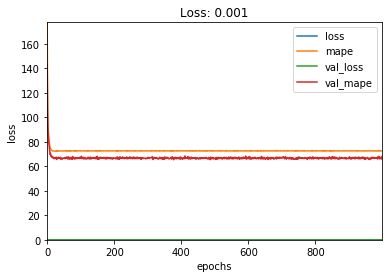

Model: "model_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_50 (InputLayer)        [(None, 13)]              0         
_________________________________________________________________
dense_40 (Dense)             (None, 12)                168       
_________________________________________________________________
dense_41 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_42 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_43 (Dense)             (None, 12)                156       
Total params: 636
Trainable params: 156
Non-trainable params: 480
_________________________________________________________________
None


In [274]:
#Koopman_train_timestep=2
Koopman_model_time2 = Koopman_trainer(autoencoder_model,2,x_train)
print(Koopman_model_time2.summary())

(9354, 13)
(9354, 13)


W0330 14:59:14.924854 140619686774592 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


(9354, 12)
Train on 7483 samples, validate on 1871 samples
Epoch 1/1000
7483/7483 [==============================] - 0s 53us/sample - loss: 0.0047 - mape: 168.2424 - val_loss: 0.0058 - val_mape: 142.9484
Epoch 2/1000
7483/7483 [==============================] - 0s 34us/sample - loss: 0.0031 - mape: 127.8475 - val_loss: 0.0040 - val_mape: 109.4425
Epoch 3/1000
7483/7483 [==============================] - 0s 31us/sample - loss: 0.0024 - mape: 107.1855 - val_loss: 0.0032 - val_mape: 95.0505
Epoch 4/1000
7483/7483 [==============================] - 0s 32us/sample - loss: 0.0020 - mape: 96.8328 - val_loss: 0.0027 - val_mape: 87.0191
Epoch 5/1000
7483/7483 [==============================] - 0s 36us/sample - loss: 0.0019 - mape: 91.6615 - val_loss: 0.0024 - val_mape: 83.3481
Epoch 6/1000
7483/7483 [==============================] - 0s 41us/sample - loss: 0.0017 - mape: 88.6939 - val_loss: 0.0022 - val_mape: 81.8516
Epoch 7/1000
7483/7483 [==============================] - 0s 33us/sample - los

7483/7483 [==============================] - 0s 25us/sample - loss: 0.0014 - mape: 82.1364 - val_loss: 0.0016 - val_mape: 78.6159
Epoch 58/1000
7483/7483 [==============================] - 0s 23us/sample - loss: 0.0014 - mape: 82.0256 - val_loss: 0.0016 - val_mape: 79.2914
Epoch 59/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.0377 - val_loss: 0.0016 - val_mape: 79.0729
Epoch 60/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.0173 - val_loss: 0.0016 - val_mape: 78.3056
Epoch 61/1000
7483/7483 [==============================] - 0s 23us/sample - loss: 0.0014 - mape: 82.1367 - val_loss: 0.0016 - val_mape: 77.4184
Epoch 62/1000
7483/7483 [==============================] - 0s 23us/sample - loss: 0.0014 - mape: 81.9852 - val_loss: 0.0016 - val_mape: 80.6682
Epoch 63/1000
7483/7483 [==============================] - 0s 23us/sample - loss: 0.0014 - mape: 82.1675 - val_loss: 0.0016 - val_mape: 77.8201
Epoch 

Epoch 114/1000
7483/7483 [==============================] - 0s 24us/sample - loss: 0.0014 - mape: 82.3295 - val_loss: 0.0016 - val_mape: 79.0771
Epoch 115/1000
7483/7483 [==============================] - 0s 24us/sample - loss: 0.0014 - mape: 82.0897 - val_loss: 0.0016 - val_mape: 80.2546
Epoch 116/1000
7483/7483 [==============================] - 0s 24us/sample - loss: 0.0014 - mape: 82.1879 - val_loss: 0.0016 - val_mape: 78.5527
Epoch 117/1000
7483/7483 [==============================] - 0s 23us/sample - loss: 0.0014 - mape: 82.2548 - val_loss: 0.0016 - val_mape: 79.6893
Epoch 118/1000
7483/7483 [==============================] - 0s 26us/sample - loss: 0.0014 - mape: 82.0858 - val_loss: 0.0015 - val_mape: 77.5976
Epoch 119/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 81.9362 - val_loss: 0.0016 - val_mape: 80.6165
Epoch 120/1000
7483/7483 [==============================] - 0s 24us/sample - loss: 0.0014 - mape: 82.3340 - val_loss: 0.0016 - val

7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.2049 - val_loss: 0.0016 - val_mape: 78.1203
Epoch 171/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.1105 - val_loss: 0.0016 - val_mape: 78.2356
Epoch 172/1000
7483/7483 [==============================] - 0s 21us/sample - loss: 0.0014 - mape: 82.1015 - val_loss: 0.0016 - val_mape: 78.8071
Epoch 173/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.1941 - val_loss: 0.0015 - val_mape: 77.4049
Epoch 174/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.0490 - val_loss: 0.0016 - val_mape: 78.7327
Epoch 175/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.2234 - val_loss: 0.0016 - val_mape: 78.6207
Epoch 176/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.0534 - val_loss: 0.0016 - val_mape: 79.2493


7483/7483 [==============================] - 0s 23us/sample - loss: 0.0014 - mape: 82.0617 - val_loss: 0.0016 - val_mape: 78.7178
Epoch 227/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.2424 - val_loss: 0.0016 - val_mape: 78.2541
Epoch 228/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.1367 - val_loss: 0.0016 - val_mape: 77.9213
Epoch 229/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.2183 - val_loss: 0.0016 - val_mape: 78.1266
Epoch 230/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.0518 - val_loss: 0.0016 - val_mape: 78.1491
Epoch 231/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.0738 - val_loss: 0.0016 - val_mape: 79.4493
Epoch 232/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.2870 - val_loss: 0.0016 - val_mape: 79.1059


7483/7483 [==============================] - 0s 23us/sample - loss: 0.0014 - mape: 82.2800 - val_loss: 0.0016 - val_mape: 78.8092
Epoch 283/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.1505 - val_loss: 0.0016 - val_mape: 77.9472
Epoch 284/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 81.9474 - val_loss: 0.0016 - val_mape: 79.5260
Epoch 285/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.2076 - val_loss: 0.0016 - val_mape: 79.5719
Epoch 286/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.1109 - val_loss: 0.0016 - val_mape: 79.3797
Epoch 287/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.1630 - val_loss: 0.0016 - val_mape: 79.0188
Epoch 288/1000
7483/7483 [==============================] - 0s 23us/sample - loss: 0.0014 - mape: 82.1365 - val_loss: 0.0016 - val_mape: 78.5000


7483/7483 [==============================] - 0s 23us/sample - loss: 0.0014 - mape: 82.0679 - val_loss: 0.0015 - val_mape: 77.9065
Epoch 339/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.2669 - val_loss: 0.0016 - val_mape: 79.1469
Epoch 340/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.2479 - val_loss: 0.0016 - val_mape: 78.5176
Epoch 341/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.1209 - val_loss: 0.0016 - val_mape: 78.1890
Epoch 342/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 81.9695 - val_loss: 0.0016 - val_mape: 79.6002
Epoch 343/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.2816 - val_loss: 0.0016 - val_mape: 78.6765
Epoch 344/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.1537 - val_loss: 0.0016 - val_mape: 79.0071


7483/7483 [==============================] - 0s 23us/sample - loss: 0.0014 - mape: 82.1463 - val_loss: 0.0016 - val_mape: 78.7851
Epoch 395/1000
7483/7483 [==============================] - 0s 23us/sample - loss: 0.0014 - mape: 82.3873 - val_loss: 0.0016 - val_mape: 78.1527
Epoch 396/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 81.9412 - val_loss: 0.0016 - val_mape: 79.6633
Epoch 397/1000
7483/7483 [==============================] - 0s 23us/sample - loss: 0.0014 - mape: 82.1515 - val_loss: 0.0016 - val_mape: 80.6445
Epoch 398/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.2559 - val_loss: 0.0016 - val_mape: 78.4594
Epoch 399/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.0366 - val_loss: 0.0016 - val_mape: 77.9392
Epoch 400/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.1267 - val_loss: 0.0016 - val_mape: 78.7888


7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.0826 - val_loss: 0.0016 - val_mape: 77.3242
Epoch 451/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.0296 - val_loss: 0.0016 - val_mape: 78.8970
Epoch 452/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.2582 - val_loss: 0.0016 - val_mape: 79.4568
Epoch 453/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.0876 - val_loss: 0.0016 - val_mape: 79.6402
Epoch 454/1000
7483/7483 [==============================] - 0s 27us/sample - loss: 0.0014 - mape: 82.2481 - val_loss: 0.0016 - val_mape: 78.6708
Epoch 455/1000
7483/7483 [==============================] - 0s 23us/sample - loss: 0.0014 - mape: 82.0851 - val_loss: 0.0015 - val_mape: 77.8490
Epoch 456/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.1216 - val_loss: 0.0016 - val_mape: 77.8748


7483/7483 [==============================] - 0s 23us/sample - loss: 0.0014 - mape: 82.1030 - val_loss: 0.0016 - val_mape: 78.9202
Epoch 507/1000
7483/7483 [==============================] - 0s 23us/sample - loss: 0.0014 - mape: 82.1654 - val_loss: 0.0016 - val_mape: 79.3307
Epoch 508/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.3039 - val_loss: 0.0016 - val_mape: 79.7324
Epoch 509/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.2029 - val_loss: 0.0016 - val_mape: 78.0582
Epoch 510/1000
7483/7483 [==============================] - 0s 23us/sample - loss: 0.0014 - mape: 81.9884 - val_loss: 0.0016 - val_mape: 78.3460
Epoch 511/1000
7483/7483 [==============================] - 0s 23us/sample - loss: 0.0014 - mape: 82.1076 - val_loss: 0.0016 - val_mape: 79.7084
Epoch 512/1000
7483/7483 [==============================] - 0s 23us/sample - loss: 0.0014 - mape: 82.2367 - val_loss: 0.0016 - val_mape: 77.9512


7483/7483 [==============================] - 0s 23us/sample - loss: 0.0014 - mape: 82.1110 - val_loss: 0.0016 - val_mape: 78.6247
Epoch 563/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.2698 - val_loss: 0.0016 - val_mape: 79.4100
Epoch 564/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.0314 - val_loss: 0.0016 - val_mape: 78.5871
Epoch 565/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.1755 - val_loss: 0.0016 - val_mape: 77.9661
Epoch 566/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.1660 - val_loss: 0.0016 - val_mape: 78.8191
Epoch 567/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.1094 - val_loss: 0.0016 - val_mape: 78.9077
Epoch 568/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.1470 - val_loss: 0.0016 - val_mape: 78.9314


7483/7483 [==============================] - 0s 23us/sample - loss: 0.0014 - mape: 82.3228 - val_loss: 0.0016 - val_mape: 79.4374
Epoch 619/1000
7483/7483 [==============================] - 0s 24us/sample - loss: 0.0014 - mape: 82.0785 - val_loss: 0.0016 - val_mape: 78.8314
Epoch 620/1000
7483/7483 [==============================] - 0s 25us/sample - loss: 0.0014 - mape: 82.2099 - val_loss: 0.0016 - val_mape: 78.4433
Epoch 621/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.2123 - val_loss: 0.0016 - val_mape: 77.8386
Epoch 622/1000
7483/7483 [==============================] - 0s 24us/sample - loss: 0.0014 - mape: 82.1135 - val_loss: 0.0016 - val_mape: 79.6707
Epoch 623/1000
7483/7483 [==============================] - 0s 23us/sample - loss: 0.0014 - mape: 82.0844 - val_loss: 0.0016 - val_mape: 78.9922
Epoch 624/1000
7483/7483 [==============================] - 0s 23us/sample - loss: 0.0014 - mape: 82.1153 - val_loss: 0.0016 - val_mape: 78.7085


7483/7483 [==============================] - 0s 23us/sample - loss: 0.0014 - mape: 82.1611 - val_loss: 0.0016 - val_mape: 79.9252
Epoch 675/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.2397 - val_loss: 0.0016 - val_mape: 79.2062
Epoch 676/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.0458 - val_loss: 0.0016 - val_mape: 78.4099
Epoch 677/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.1877 - val_loss: 0.0016 - val_mape: 77.8379
Epoch 678/1000
7483/7483 [==============================] - 0s 23us/sample - loss: 0.0014 - mape: 82.2130 - val_loss: 0.0016 - val_mape: 79.0395
Epoch 679/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.1520 - val_loss: 0.0016 - val_mape: 78.4275
Epoch 680/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.1100 - val_loss: 0.0016 - val_mape: 79.3053


7483/7483 [==============================] - 0s 23us/sample - loss: 0.0014 - mape: 82.1536 - val_loss: 0.0016 - val_mape: 78.4505
Epoch 731/1000
7483/7483 [==============================] - 0s 23us/sample - loss: 0.0014 - mape: 82.1046 - val_loss: 0.0016 - val_mape: 78.9827
Epoch 732/1000
7483/7483 [==============================] - 0s 23us/sample - loss: 0.0014 - mape: 82.1837 - val_loss: 0.0016 - val_mape: 78.2194
Epoch 733/1000
7483/7483 [==============================] - 0s 23us/sample - loss: 0.0014 - mape: 82.1855 - val_loss: 0.0016 - val_mape: 78.3990
Epoch 734/1000
7483/7483 [==============================] - 0s 24us/sample - loss: 0.0014 - mape: 82.1040 - val_loss: 0.0016 - val_mape: 79.1376
Epoch 735/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.1209 - val_loss: 0.0016 - val_mape: 78.0723
Epoch 736/1000
7483/7483 [==============================] - 0s 24us/sample - loss: 0.0014 - mape: 82.0562 - val_loss: 0.0016 - val_mape: 80.8701


7483/7483 [==============================] - 0s 28us/sample - loss: 0.0014 - mape: 82.1211 - val_loss: 0.0016 - val_mape: 79.0688
Epoch 787/1000
7483/7483 [==============================] - 0s 27us/sample - loss: 0.0014 - mape: 82.1110 - val_loss: 0.0016 - val_mape: 80.1174
Epoch 788/1000
7483/7483 [==============================] - 0s 23us/sample - loss: 0.0014 - mape: 82.1294 - val_loss: 0.0016 - val_mape: 77.6678
Epoch 789/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.1556 - val_loss: 0.0016 - val_mape: 78.5101
Epoch 790/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.0279 - val_loss: 0.0016 - val_mape: 79.2745
Epoch 791/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.2802 - val_loss: 0.0016 - val_mape: 78.4640
Epoch 792/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.1007 - val_loss: 0.0016 - val_mape: 78.9901


7483/7483 [==============================] - 0s 24us/sample - loss: 0.0014 - mape: 82.2560 - val_loss: 0.0016 - val_mape: 78.8556
Epoch 843/1000
7483/7483 [==============================] - 0s 23us/sample - loss: 0.0014 - mape: 81.9698 - val_loss: 0.0015 - val_mape: 78.0011
Epoch 844/1000
7483/7483 [==============================] - 0s 24us/sample - loss: 0.0014 - mape: 82.2350 - val_loss: 0.0016 - val_mape: 79.3533
Epoch 845/1000
7483/7483 [==============================] - 0s 24us/sample - loss: 0.0014 - mape: 82.2013 - val_loss: 0.0016 - val_mape: 80.3045
Epoch 846/1000
7483/7483 [==============================] - 0s 23us/sample - loss: 0.0014 - mape: 82.1897 - val_loss: 0.0016 - val_mape: 77.6888
Epoch 847/1000
7483/7483 [==============================] - 0s 26us/sample - loss: 0.0014 - mape: 82.0554 - val_loss: 0.0016 - val_mape: 77.9851
Epoch 848/1000
7483/7483 [==============================] - 0s 28us/sample - loss: 0.0014 - mape: 82.1377 - val_loss: 0.0016 - val_mape: 78.7989


7483/7483 [==============================] - 0s 26us/sample - loss: 0.0014 - mape: 82.0539 - val_loss: 0.0016 - val_mape: 79.8726
Epoch 899/1000
7483/7483 [==============================] - 0s 27us/sample - loss: 0.0014 - mape: 82.2776 - val_loss: 0.0016 - val_mape: 78.6468
Epoch 900/1000
7483/7483 [==============================] - 0s 21us/sample - loss: 0.0014 - mape: 82.0310 - val_loss: 0.0016 - val_mape: 79.0181
Epoch 901/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.2326 - val_loss: 0.0016 - val_mape: 78.1776
Epoch 902/1000
7483/7483 [==============================] - 0s 21us/sample - loss: 0.0014 - mape: 82.2350 - val_loss: 0.0016 - val_mape: 78.7043
Epoch 903/1000
7483/7483 [==============================] - 0s 20us/sample - loss: 0.0014 - mape: 82.1179 - val_loss: 0.0016 - val_mape: 79.5915
Epoch 904/1000
7483/7483 [==============================] - 0s 21us/sample - loss: 0.0014 - mape: 82.2417 - val_loss: 0.0016 - val_mape: 78.2899


7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.0659 - val_loss: 0.0016 - val_mape: 78.8475
Epoch 955/1000
7483/7483 [==============================] - 0s 26us/sample - loss: 0.0014 - mape: 82.1289 - val_loss: 0.0016 - val_mape: 78.0612
Epoch 956/1000
7483/7483 [==============================] - 0s 23us/sample - loss: 0.0014 - mape: 82.1182 - val_loss: 0.0016 - val_mape: 78.4020
Epoch 957/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.1020 - val_loss: 0.0016 - val_mape: 79.9386
Epoch 958/1000
7483/7483 [==============================] - 0s 22us/sample - loss: 0.0014 - mape: 82.1401 - val_loss: 0.0016 - val_mape: 78.8502
Epoch 959/1000
7483/7483 [==============================] - 0s 21us/sample - loss: 0.0014 - mape: 82.3798 - val_loss: 0.0016 - val_mape: 78.5996
Epoch 960/1000
7483/7483 [==============================] - 0s 21us/sample - loss: 0.0014 - mape: 81.9147 - val_loss: 0.0016 - val_mape: 79.4447


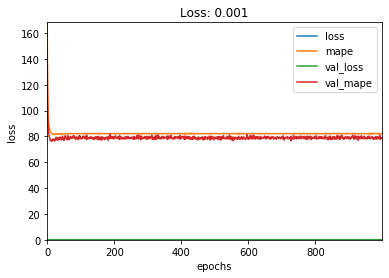

Model: "model_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        [(None, 13)]              0         
_________________________________________________________________
dense_44 (Dense)             (None, 12)                168       
_________________________________________________________________
dense_45 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_46 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_47 (Dense)             (None, 12)                156       
Total params: 636
Trainable params: 156
Non-trainable params: 480
_________________________________________________________________
None


In [275]:
#Koopman_train_timestep=3
Koopman_model_time3 = Koopman_trainer(autoencoder_model,3,x_train)
print(Koopman_model_time3.summary())

(9351, 13)
(9351, 13)
(9351, 12)


W0330 15:07:38.048267 140619686774592 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


Train on 7480 samples, validate on 1871 samples
Epoch 1/1000
7480/7480 [==============================] - 0s 36us/sample - loss: 0.0050 - mape: 191.1761 - val_loss: 0.0052 - val_mape: 161.0508
Epoch 2/1000
7480/7480 [==============================] - 0s 23us/sample - loss: 0.0035 - mape: 146.9329 - val_loss: 0.0040 - val_mape: 129.7944
Epoch 3/1000
7480/7480 [==============================] - 0s 22us/sample - loss: 0.0029 - mape: 123.1392 - val_loss: 0.0034 - val_mape: 113.1182
Epoch 4/1000
7480/7480 [==============================] - 0s 23us/sample - loss: 0.0025 - mape: 110.4048 - val_loss: 0.0031 - val_mape: 104.7297
Epoch 5/1000
7480/7480 [==============================] - 0s 27us/sample - loss: 0.0024 - mape: 103.1157 - val_loss: 0.0029 - val_mape: 99.7409
Epoch 6/1000
7480/7480 [==============================] - 0s 26us/sample - loss: 0.0022 - mape: 99.1395 - val_loss: 0.0028 - val_mape: 95.3887
Epoch 7/1000
7480/7480 [==============================] - 0s 23us/sample - loss: 0.00

7480/7480 [==============================] - 0s 25us/sample - loss: 0.0018 - mape: 90.9720 - val_loss: 0.0023 - val_mape: 95.0468
Epoch 58/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 90.9352 - val_loss: 0.0022 - val_mape: 93.9318
Epoch 59/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 91.0158 - val_loss: 0.0023 - val_mape: 94.7420
Epoch 60/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 90.8822 - val_loss: 0.0023 - val_mape: 95.0114
Epoch 61/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 90.9949 - val_loss: 0.0023 - val_mape: 94.5987
Epoch 62/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 90.9705 - val_loss: 0.0023 - val_mape: 97.4660
Epoch 63/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 91.0331 - val_loss: 0.0022 - val_mape: 94.1860
Epoch 

Epoch 114/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 91.1794 - val_loss: 0.0023 - val_mape: 94.0644
Epoch 115/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 91.0102 - val_loss: 0.0023 - val_mape: 93.6936
Epoch 116/1000
7480/7480 [==============================] - 0s 22us/sample - loss: 0.0018 - mape: 90.8465 - val_loss: 0.0023 - val_mape: 94.3887
Epoch 117/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 90.9708 - val_loss: 0.0023 - val_mape: 95.6905
Epoch 118/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 90.9810 - val_loss: 0.0023 - val_mape: 96.0747
Epoch 119/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 90.9877 - val_loss: 0.0022 - val_mape: 94.5232
Epoch 120/1000
7480/7480 [==============================] - 0s 22us/sample - loss: 0.0018 - mape: 91.1341 - val_loss: 0.0023 - val

7480/7480 [==============================] - 0s 25us/sample - loss: 0.0018 - mape: 90.8678 - val_loss: 0.0023 - val_mape: 96.5454
Epoch 171/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 91.1179 - val_loss: 0.0023 - val_mape: 96.2802
Epoch 172/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 90.9635 - val_loss: 0.0023 - val_mape: 95.2037
Epoch 173/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 91.0191 - val_loss: 0.0023 - val_mape: 96.2978
Epoch 174/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 91.0898 - val_loss: 0.0022 - val_mape: 94.0008
Epoch 175/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 91.0493 - val_loss: 0.0023 - val_mape: 94.2321
Epoch 176/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 90.9258 - val_loss: 0.0023 - val_mape: 96.9372


7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 91.0260 - val_loss: 0.0023 - val_mape: 93.3032
Epoch 227/1000
7480/7480 [==============================] - 0s 22us/sample - loss: 0.0018 - mape: 91.1094 - val_loss: 0.0023 - val_mape: 96.1252
Epoch 228/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 90.9279 - val_loss: 0.0023 - val_mape: 96.6711
Epoch 229/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 91.0844 - val_loss: 0.0022 - val_mape: 95.0726
Epoch 230/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 91.0499 - val_loss: 0.0023 - val_mape: 95.6368
Epoch 231/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 90.8695 - val_loss: 0.0023 - val_mape: 96.4259
Epoch 232/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 91.1273 - val_loss: 0.0023 - val_mape: 94.3478


7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 90.9357 - val_loss: 0.0022 - val_mape: 94.8396
Epoch 283/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 91.2322 - val_loss: 0.0023 - val_mape: 96.4579
Epoch 284/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 90.9220 - val_loss: 0.0023 - val_mape: 98.1566
Epoch 285/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 91.1701 - val_loss: 0.0023 - val_mape: 94.2960
Epoch 286/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 90.9781 - val_loss: 0.0023 - val_mape: 95.9045
Epoch 287/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 90.9180 - val_loss: 0.0023 - val_mape: 97.1221
Epoch 288/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 91.1986 - val_loss: 0.0023 - val_mape: 94.4219


7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 90.8578 - val_loss: 0.0023 - val_mape: 96.5574
Epoch 339/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 91.1067 - val_loss: 0.0023 - val_mape: 96.2997
Epoch 340/1000
7480/7480 [==============================] - 0s 22us/sample - loss: 0.0018 - mape: 90.9661 - val_loss: 0.0023 - val_mape: 97.2155
Epoch 341/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 91.0278 - val_loss: 0.0023 - val_mape: 93.9315
Epoch 342/1000
7480/7480 [==============================] - 0s 28us/sample - loss: 0.0018 - mape: 90.9560 - val_loss: 0.0023 - val_mape: 98.3327
Epoch 343/1000
7480/7480 [==============================] - 0s 24us/sample - loss: 0.0018 - mape: 91.1408 - val_loss: 0.0023 - val_mape: 95.4033
Epoch 344/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 90.9116 - val_loss: 0.0023 - val_mape: 96.5358


7480/7480 [==============================] - 0s 22us/sample - loss: 0.0018 - mape: 91.0739 - val_loss: 0.0022 - val_mape: 94.2444
Epoch 395/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 90.9211 - val_loss: 0.0023 - val_mape: 96.0726
Epoch 396/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 91.0438 - val_loss: 0.0023 - val_mape: 94.1130
Epoch 397/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 90.9308 - val_loss: 0.0023 - val_mape: 96.8704
Epoch 398/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 91.1465 - val_loss: 0.0023 - val_mape: 95.1236
Epoch 399/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 91.0666 - val_loss: 0.0023 - val_mape: 94.4516
Epoch 400/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 91.0842 - val_loss: 0.0022 - val_mape: 94.5989


7480/7480 [==============================] - 0s 24us/sample - loss: 0.0018 - mape: 90.9684 - val_loss: 0.0023 - val_mape: 97.0086
Epoch 451/1000
7480/7480 [==============================] - 0s 24us/sample - loss: 0.0018 - mape: 91.1354 - val_loss: 0.0023 - val_mape: 93.4729
Epoch 452/1000
7480/7480 [==============================] - 0s 23us/sample - loss: 0.0018 - mape: 90.8545 - val_loss: 0.0023 - val_mape: 96.1097
Epoch 453/1000
7480/7480 [==============================] - 0s 23us/sample - loss: 0.0018 - mape: 91.0603 - val_loss: 0.0023 - val_mape: 97.4409
Epoch 454/1000
7480/7480 [==============================] - 0s 23us/sample - loss: 0.0018 - mape: 91.0424 - val_loss: 0.0023 - val_mape: 96.4537
Epoch 455/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 91.0101 - val_loss: 0.0023 - val_mape: 96.8925
Epoch 456/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 91.0054 - val_loss: 0.0023 - val_mape: 96.4096


7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 90.9784 - val_loss: 0.0023 - val_mape: 95.8951
Epoch 507/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 91.0006 - val_loss: 0.0022 - val_mape: 94.0310
Epoch 508/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 91.0105 - val_loss: 0.0022 - val_mape: 94.2832
Epoch 509/1000
7480/7480 [==============================] - 0s 19us/sample - loss: 0.0018 - mape: 91.1026 - val_loss: 0.0023 - val_mape: 92.8971
Epoch 510/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 90.9243 - val_loss: 0.0022 - val_mape: 93.8297
Epoch 511/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 91.0012 - val_loss: 0.0023 - val_mape: 97.8967
Epoch 512/1000
7480/7480 [==============================] - 0s 19us/sample - loss: 0.0018 - mape: 91.0727 - val_loss: 0.0023 - val_mape: 96.4059


7480/7480 [==============================] - 0s 19us/sample - loss: 0.0018 - mape: 90.9649 - val_loss: 0.0023 - val_mape: 95.3929
Epoch 563/1000
7480/7480 [==============================] - 0s 19us/sample - loss: 0.0018 - mape: 91.0862 - val_loss: 0.0023 - val_mape: 94.1692
Epoch 564/1000
7480/7480 [==============================] - 0s 19us/sample - loss: 0.0018 - mape: 90.9793 - val_loss: 0.0023 - val_mape: 96.9251
Epoch 565/1000
7480/7480 [==============================] - 0s 19us/sample - loss: 0.0018 - mape: 91.0807 - val_loss: 0.0023 - val_mape: 94.4897
Epoch 566/1000
7480/7480 [==============================] - 0s 19us/sample - loss: 0.0018 - mape: 90.9645 - val_loss: 0.0022 - val_mape: 95.2910
Epoch 567/1000
7480/7480 [==============================] - 0s 19us/sample - loss: 0.0018 - mape: 90.9507 - val_loss: 0.0023 - val_mape: 94.3092
Epoch 568/1000
7480/7480 [==============================] - 0s 19us/sample - loss: 0.0018 - mape: 91.0942 - val_loss: 0.0023 - val_mape: 96.2965


7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 90.9605 - val_loss: 0.0023 - val_mape: 95.0181
Epoch 619/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 91.0954 - val_loss: 0.0023 - val_mape: 96.1659
Epoch 620/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 91.0489 - val_loss: 0.0023 - val_mape: 95.9395
Epoch 621/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 90.8853 - val_loss: 0.0023 - val_mape: 96.0537
Epoch 622/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 90.9250 - val_loss: 0.0023 - val_mape: 96.4784
Epoch 623/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 91.0884 - val_loss: 0.0023 - val_mape: 94.2938
Epoch 624/1000
7480/7480 [==============================] - 0s 22us/sample - loss: 0.0018 - mape: 91.0146 - val_loss: 0.0022 - val_mape: 94.3405


7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 90.9983 - val_loss: 0.0023 - val_mape: 97.6865
Epoch 675/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 91.0627 - val_loss: 0.0023 - val_mape: 96.3346
Epoch 676/1000
7480/7480 [==============================] - 0s 19us/sample - loss: 0.0018 - mape: 91.1073 - val_loss: 0.0023 - val_mape: 96.0841
Epoch 677/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 90.8855 - val_loss: 0.0023 - val_mape: 96.3450
Epoch 678/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 91.1538 - val_loss: 0.0023 - val_mape: 97.1017
Epoch 679/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 91.0047 - val_loss: 0.0022 - val_mape: 93.8192
Epoch 680/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 91.0149 - val_loss: 0.0023 - val_mape: 94.6912


7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 90.8306 - val_loss: 0.0023 - val_mape: 94.7168
Epoch 731/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 91.0737 - val_loss: 0.0022 - val_mape: 93.2693
Epoch 732/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 91.0129 - val_loss: 0.0023 - val_mape: 94.8867
Epoch 733/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 90.9956 - val_loss: 0.0023 - val_mape: 96.0973
Epoch 734/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 90.7715 - val_loss: 0.0023 - val_mape: 98.5823
Epoch 735/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 91.1359 - val_loss: 0.0023 - val_mape: 95.7171
Epoch 736/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 90.9834 - val_loss: 0.0023 - val_mape: 95.4212


7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 90.8885 - val_loss: 0.0023 - val_mape: 95.5946
Epoch 787/1000
7480/7480 [==============================] - 0s 19us/sample - loss: 0.0018 - mape: 91.0744 - val_loss: 0.0023 - val_mape: 95.0395
Epoch 788/1000
7480/7480 [==============================] - 0s 19us/sample - loss: 0.0018 - mape: 91.0216 - val_loss: 0.0023 - val_mape: 95.1504
Epoch 789/1000
7480/7480 [==============================] - 0s 19us/sample - loss: 0.0018 - mape: 90.9298 - val_loss: 0.0023 - val_mape: 95.4385
Epoch 790/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 90.9258 - val_loss: 0.0023 - val_mape: 98.4412
Epoch 791/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 91.0836 - val_loss: 0.0023 - val_mape: 97.7023
Epoch 792/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 91.1289 - val_loss: 0.0023 - val_mape: 95.2953


7480/7480 [==============================] - 0s 19us/sample - loss: 0.0018 - mape: 90.8879 - val_loss: 0.0023 - val_mape: 98.0548
Epoch 843/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 91.1615 - val_loss: 0.0023 - val_mape: 95.5308
Epoch 844/1000
7480/7480 [==============================] - 0s 19us/sample - loss: 0.0018 - mape: 90.9254 - val_loss: 0.0023 - val_mape: 94.7208
Epoch 845/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 91.1261 - val_loss: 0.0023 - val_mape: 94.5761
Epoch 846/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 91.1519 - val_loss: 0.0023 - val_mape: 95.8209
Epoch 847/1000
7480/7480 [==============================] - 0s 19us/sample - loss: 0.0018 - mape: 90.9580 - val_loss: 0.0023 - val_mape: 95.6573
Epoch 848/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 90.9737 - val_loss: 0.0023 - val_mape: 95.3269


7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 91.0161 - val_loss: 0.0023 - val_mape: 94.8094
Epoch 899/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 91.0220 - val_loss: 0.0023 - val_mape: 95.1506
Epoch 900/1000
7480/7480 [==============================] - 0s 19us/sample - loss: 0.0018 - mape: 90.9186 - val_loss: 0.0023 - val_mape: 94.6724
Epoch 901/1000
7480/7480 [==============================] - 0s 19us/sample - loss: 0.0018 - mape: 91.0623 - val_loss: 0.0023 - val_mape: 93.6547
Epoch 902/1000
7480/7480 [==============================] - 0s 19us/sample - loss: 0.0018 - mape: 90.9586 - val_loss: 0.0023 - val_mape: 94.3957
Epoch 903/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 91.1886 - val_loss: 0.0023 - val_mape: 95.5008
Epoch 904/1000
7480/7480 [==============================] - 0s 21us/sample - loss: 0.0018 - mape: 90.9823 - val_loss: 0.0023 - val_mape: 96.3728


7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 91.1376 - val_loss: 0.0023 - val_mape: 95.2345
Epoch 955/1000
7480/7480 [==============================] - 0s 19us/sample - loss: 0.0018 - mape: 91.0122 - val_loss: 0.0023 - val_mape: 95.4652
Epoch 956/1000
7480/7480 [==============================] - 0s 19us/sample - loss: 0.0018 - mape: 91.0412 - val_loss: 0.0022 - val_mape: 93.9214
Epoch 957/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 91.0926 - val_loss: 0.0023 - val_mape: 96.0589
Epoch 958/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 91.0150 - val_loss: 0.0023 - val_mape: 95.7502
Epoch 959/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 91.0158 - val_loss: 0.0023 - val_mape: 94.9577
Epoch 960/1000
7480/7480 [==============================] - 0s 20us/sample - loss: 0.0018 - mape: 90.9471 - val_loss: 0.0023 - val_mape: 95.7623


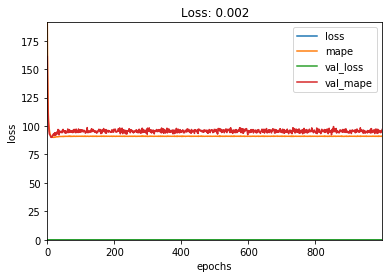

Model: "model_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        [(None, 13)]              0         
_________________________________________________________________
dense_48 (Dense)             (None, 12)                168       
_________________________________________________________________
dense_49 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_50 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_51 (Dense)             (None, 12)                156       
Total params: 636
Trainable params: 156
Non-trainable params: 480
_________________________________________________________________
None


In [276]:
#Koopman_train_timestep=6
Koopman_model_time6 = Koopman_trainer(autoencoder_model,6,x_train)
print(Koopman_model_time6.summary())

In [ ]:
"""def data_setup(choice):
    
    x_predict = x_train.loc[choice:choice+119,:]
    # Dropping the header and index
    x_predict= x_predict.reset_index(drop=True)
    x_predict.to_csv('your_array.csv', header=False, index=False)
    x_predict = pd.read_csv('your_array.csv', header= None)
    
    return x_predict"""

In [315]:
# 120 timestep data selection
#choice1 = rand.randint(0,2000)
#choice2 = rand.randint(2200,4200)
#choice3 = rand.randint(4400,6400)
#choice4 = rand.randint(6600,8600)

x_predict = x_train.loc[choice1:choice1+119,:]
# Dropping the header and index
x_predict= x_predict.reset_index(drop=True)
x_predict.to_csv('your_array.csv', header=False, index=False)
x_predict = pd.read_csv('your_array.csv', header= None)



In [316]:
# time step 1 data prediction
code_layer = fullmodel_predict(autoencoder_model,Koopman_model_time1,x_predict,1)
output_vals_time1 = decoder(autoencoder_model,code_layer)


W0330 15:34:19.835127 140619686774592 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


(None, 12)
(None, 12)


In [317]:
# time step 6 data prediction
code_layer = fullmodel_predict(autoencoder_model,Koopman_model_time6,x_predict,6)
output_vals_time6 = decoder(autoencoder_model,code_layer)


W0330 15:34:20.475771 140619686774592 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


(None, 12)
(None, 12)


In [318]:
# time step 2 data prediction
code_layer = fullmodel_predict(autoencoder_model,Koopman_model_time2,x_predict,2)
output_vals_time2 = decoder(autoencoder_model,code_layer)

W0330 15:34:21.094160 140619686774592 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


(None, 12)
(None, 12)


In [319]:
# time step 3 data prediction
code_layer = fullmodel_predict(autoencoder_model,Koopman_model_time3,x_predict,3)
output_vals_time3 = decoder(autoencoder_model,code_layer)

W0330 15:34:21.781857 140619686774592 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


(None, 12)
(None, 12)


In [320]:
# writing into excel file
output_dict = {"x(k)":x_predict,"x(k+1)":output_vals_time1,"x(k+2)":output_vals_time2,"x(k+3)":output_vals_time3,"x(k+6)":output_vals_time6}
path_to_excel = os.getcwd() + "/Koopman_samples" "/Choice-1"+ "/Koopman_output_choice1.xlsx"
save_xls(output_dict,path_to_excel)


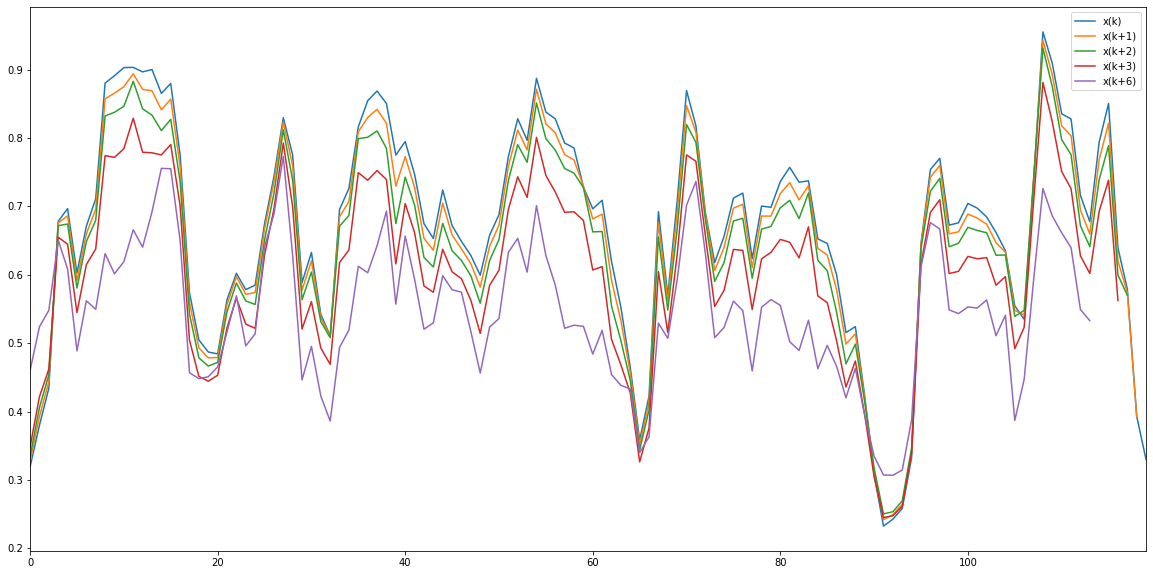

In [324]:
ax = x_predict.plot(y=11,figsize=(20,10))
output_vals_time1.plot(y=11,ax=ax)
output_vals_time2.plot(y=11,ax=ax)
output_vals_time3.plot(y=11,ax=ax)
output_vals_time6.plot(y=11,ax=ax)
ax.legend(["x(k)","x(k+1)","x(k+2)","x(k+3)","x(k+6)"])

In [282]:
choice1

1295

In [217]:
choice2

3049

In [223]:
choice3

5580

In [229]:
choice4

6999

In [231]:
output_vals_time1.shape


(119, 13)

In [233]:
output_vals_time6


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.198526,0.347219,0.177811,0.147238,0.298063,0.225021,0.194881,0.355883,0.356325,0.368451,0.296004,0.668397,0.351680
1,0.192087,0.345057,0.178605,0.147226,0.297322,0.218472,0.196753,0.347719,0.356820,0.367878,0.306342,0.663007,0.363715
2,0.184499,0.336976,0.178560,0.138421,0.286669,0.209739,0.203379,0.342338,0.345819,0.358227,0.310921,0.642048,0.363016
3,0.183574,0.338139,0.179544,0.142136,0.290520,0.209356,0.202973,0.339009,0.351186,0.359220,0.316129,0.642991,0.368378
4,0.170334,0.317674,0.176223,0.125159,0.268977,0.192700,0.215943,0.325946,0.330789,0.334306,0.308277,0.636601,0.367822
5,0.160267,0.313929,0.174683,0.116549,0.257529,0.173044,0.225625,0.307034,0.334633,0.316813,0.313386,0.643153,0.385594
6,0.194023,0.375960,0.174336,0.139419,0.286097,0.220802,0.194560,0.328644,0.363749,0.357948,0.262948,0.790059,0.413637
7,0.214640,0.402000,0.175955,0.160723,0.312687,0.249048,0.174492,0.347880,0.382605,0.395453,0.281368,0.793991,0.432899
8,0.180370,0.348996,0.172406,0.125402,0.268975,0.201936,0.205212,0.319041,0.345649,0.347743,0.272476,0.759543,0.411300
9,0.166426,0.330020,0.170957,0.119138,0.260455,0.185410,0.213095,0.306146,0.334483,0.333484,0.271184,0.749414,0.404950
